# Finding interrelations of the UN SDG Targets and impute missing observations

### This project is divided into two major phases: 
1. It is intended to find cliques within the [UN SDG](https://sustainabledevelopment.un.org/?menu=1300) Targets.
2. Within one of the found cliques, missing observations of the time-series are inferred

Each Target has at least one quantitatively measurable Indicator associated whose measurements from 1984 to 2017 serve as our data points. The data set we are working with is for the entire world, i.e. the values presented are means over all countries. Regarding the first phase, for a more sophisticated analysis, but out of scope of this course, correlations in each country should be analysed separately.

<img src="Screenshot from 2018-04-19 10-08-40.png">

## 1. Find cliques

Import necessary packages and load our preprocessed data set

*if you want to see what happened in the preprocessing, see **prepare_df_for_analysis.ipynb** *

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pystan
import math
import os

In [2]:
# load csv
df = pd.read_csv("TargetsForAnalysis.csv")
df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.7,NaN,NaN,NaN,NaN
1,107,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN
2,108,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.86,NaN
3,109,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.79,NaN
4,110,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.08,NaN


See how many data points we have for each Indicator

In [3]:
intyears = list(range(1984, 2018))
#print(intyears)

years = []
for year in intyears:
    years.append(str(year))
    
#print(years)

In [4]:
def getnumberofyearswithdata(r):
    n = 0
    for year in years:
        if ~np.isnan(r[year]):
            n+=1
    return n

In [5]:
# new column with number of data points per Indicator
df['Years with values'] = df.apply(getnumberofyearswithdata, axis=1)

In [6]:
df.head()
df.shape

(197, 43)

We need at least two data points to conclude any kind of correlation

In [7]:
df_new = df.loc[df['Years with values'] > 1]

# see how many rows we deleted
print(df_new.shape)
df_new.head()

(120, 43)


,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,10.70,NaN,NaN,NaN,NaN,2
8,115,Population,Proportion of births attended by skilled healt...,3,3.1,3.1.2,Percent,Units,NaN,NaN,...,NaN,69.88,NaN,NaN,NaN,NaN,NaN,78.49,NaN,3
9,129,Population,Participation rate in organized learning (one ...,4,4.2,4.2.2,Percent,Units,NaN,NaN,...,59.41,60.44,62.64,64.64,65.20,66.59,NaN,NaN,NaN,12
10,130,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,54.02,55.55,55.91,55.77,55.22,55.03,54.81,NaN,NaN,16
11,131,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,69.90,70.82,71.14,71.22,71.09,71.14,71.16,NaN,NaN,16


See how many Targets are associated with the Indicators we found

In [8]:
# create a list of Targets
e = list(df_new['Target'])
type(e[2])

str

In [9]:
df_new['Target'] = df_new.apply(lambda x: str(x['Target']), axis=1)

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
#list(df_new['Target'])

In [11]:
df_new.shape

(120, 43)

See which Targets are in our data frame

In [12]:
targets = list(set(df_new['Target']))
targets

['3.6',
 '6.2',
 '7.2',
 '10.c',
 '3.1',
 '8.2',
 '17.8',
 '9.2',
 '9.c',
 '9.4',
 '15.4',
 '16.a',
 '14.4',
 '7.1',
 '2.1',
 '17.3',
 '15.2',
 '3.9',
 '15.1',
 '3.4',
 '17.19',
 '4.2',
 '17.2',
 '6.1',
 '14.5',
 '8.4',
 '3.3',
 '12.2',
 '1.1',
 '6.b',
 '9.5',
 '16.3',
 '8.1']

We know that one Target can have potentially more than one Indicator, and that Indicators can be separetely measured for, e.g., genders, age groups, etc.
But since we want to find interrelations between the Targets, only the row per Target with maximum amount of data is considered.

In [13]:
# create empty dictionary
target_dfs = {}

In [14]:
for t in targets:
    target_dfs[t] = df_new[df_new['Target']==t]

In [15]:
# show an example of Target with more than on Indicator
target_dfs['12.2']

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.690000e+00,1.010000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
178,78,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
179,79,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,6.573055e+16,6.932903e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
183,83,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,9.750000e+00,1.006000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
184,84,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
185,85,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,6.807354e+16,7.099971e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


In [16]:
# find row with maximum amount of data points for each target
max_dfrows = {}

In [17]:
for target in targets:
    if target_dfs[target].shape[0] > 1:
        max_dfrows[target] = target_dfs[target].loc[target_dfs[target]['Years with values'].idxmax()].to_frame().T
    else:
        max_dfrows[target]=target_dfs[target]

In [18]:
max_dfrows

{'1.1':   Unnamed: 0    Category                              Indicator Description  \
 0        106  Population  Proportion of population below the internation...   
 
   Goal Target Indicator Ref     Unit Unit multiplier 1984 1985  \
 0    1    1.1         1.1.1  Percent           Units  NaN  NaN   
 
          ...        2009 2010 2011 2012  2013 2014 2015 2016 2017  \
 0        ...         NaN  NaN  NaN  NaN  10.7  NaN  NaN  NaN  NaN   
 
   Years with values  
 0                 2  
 
 [1 rows x 43 columns], '10.c':      Unnamed: 0       Category  \
 117          13  E&P (Percent)   
 
                                  Indicator Description  Goal Target  \
 117  Remittance costs as a proportion of the amount...    10   10.c   
 
     Indicator Ref     Unit Unit multiplier  1984  1985        ...          \
 117        10.c.1  Percent           Units   NaN   NaN        ...           
 
      2009  2010  2011  2012  2013  2014  2015  2016  2017  Years with values  
 117   NaN   NaN  

In [19]:
frames = list(max_dfrows[target] for target in targets)
frames

[    Unnamed: 0    Category                    Indicator Description  Goal  \
 65         123  Population  Death rate due to road traffic injuries     3   
 
    Target Indicator Ref     Unit Unit multiplier  1984  1985  \
 65    3.6         3.6.1  Percent           Units   NaN   NaN   
 
           ...          2009  2010  2011  2012  2013  2014  2015  2016  2017  \
 65        ...           NaN   1.8   NaN   NaN  1.74   NaN   NaN   NaN   NaN   
 
     Years with values  
 65                  4  
 
 [1 rows x 43 columns],
    Unnamed: 0    Category                              Indicator Description  \
 13        133  Population  Proportion of population using safely managed ...   
 
    Goal Target Indicator Ref     Unit Unit multiplier 1984 1985  \
 13    6    6.2         6.2.1  Percent           Units  NaN  NaN   
 
           ...          2009   2010   2011   2012   2013   2014   2015 2016  \
 13        ...         28.29  27.58  26.97  26.23  25.48  24.73  23.97  NaN   
 
    2017 Y

In [20]:
final_df = pd.concat(frames, axis=0)

In [21]:
final_df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
65,123,Population,Death rate due to road traffic injuries,3,3.6,3.6.1,Percent,Units,NaN,NaN,...,NaN,1.8,NaN,NaN,1.74,NaN,NaN,NaN,NaN,4
13,133,Population,Proportion of population using safely managed ...,6,6.2,6.2.1,Percent,Units,NaN,NaN,...,28.29,27.58,26.97,26.23,25.48,24.73,23.97,NaN,NaN,16
143,38,Environment (Percent),Renewable energy share in the total final ener...,7,7.2,7.2.1,Percent,Units,NaN,NaN,...,17.71,17.51,17.54,17.91,18.19,18.33,NaN,NaN,NaN,15
117,13,E&P (Percent),Remittance costs as a proportion of the amount...,10,10.c,10.c.1,Percent,Units,NaN,NaN,...,NaN,NaN,8.9,9,8.6,8.2,7.5,NaN,NaN,5
57,114,Population,Maternal mortality ratio,3,3.1,3.1.1,Percent,Units,NaN,NaN,...,NaN,24.6,NaN,NaN,NaN,NaN,21.6,NaN,NaN,4


### clean-up data frames

In [22]:
# Drop unused columns, transpose 
final_df.drop(['Unnamed: 0', 'Category', 'Indicator Description', 'Goal', 'Indicator Ref', 'Unit',
              'Unit multiplier', 'Years with values'], inplace=True, axis=1)

final_df = final_df.set_index('Target')

final_t = final_df.T

targets = list(final_t.columns)

In [23]:
final_t

Target,3.6,6.2,7.2,10.c,3.1,8.2,17.8,9.2,9.c,9.4,...,6.1,14.5,8.4,3.3,12.2,1.1,6.b,9.5,16.3,8.1
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# shuffle data
final_t_shuffled = final_t.sample(frac=1).reset_index(drop=True)
final_t_shuffled

Target,3.6,6.2,7.2,10.c,3.1,8.2,17.8,9.2,9.c,9.4,...,6.1,14.5,8.4,3.3,12.2,1.1,6.b,9.5,16.3,8.1
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,31.58,16.89,NaN,NaN,3.42,14.26,15.26,60.74,2.61102e+10,...,45.69,NaN,8.77,17,8.77,NaN,NaN,87.311,NaN,2.81
2,NaN,28.29,17.71,NaN,NaN,-0.71,25.66,14.99,87.32,2.87486e+10,...,54.02,NaN,9.69,15.9,9.69,NaN,NaN,100.752,NaN,-3.24
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.8,33.76,17.45,NaN,34.1,2.86,6.56,15.15,78.61,2.31445e+10,...,40.95,1.72,8,17.2,8,NaN,NaN,80.637,NaN,3.01
6,NaN,28.98,17.14,NaN,NaN,1.83,23.18,15.74,84.22,2.91648e+10,...,52.49,NaN,9.78,16.1,9.78,NaN,NaN,98.358,NaN,0.2
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,21.62,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.74,25.48,18.19,8.6,NaN,1.93,37.18,15.99,95.54,3.21294e+10,...,55.22,NaN,NaN,14.7,NaN,10.7,NaN,108.754,NaN,1.08


### R-squared value of linear regression to detect connections

In [25]:
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import Imputer

mask_train = ~np.isnan(targets_X_train) & ~np.isnan(targets_Y_train)
print(mask_train)
targets_X_train = final_t_shuffled[targetx][:-6].reshape(-1, 1)
print(targets_X_train)
print(targets_X_train[mask_train])

In [26]:
# old version for environment
keep =[]
for targetx in targets:     #loop over all rows
        
        for targety in targets:    #loop over all rows except the one we're in now
            
            # Split the data into training/testing sets
            targets_X_train = final_t_shuffled[targetx][:-6]
            print(type(targets_X_train))
            targets_X_train = targets_X_train.reshape(-1, 1)
            print("Train var", targets_X_train, type(targets_X_train))
            targets_X_valid = final_t_shuffled[targetx][-6:].reshape(-1, 1) 
            print("Validation var", targets_X_valid, type(targets_X_valid))
        
            # Split the data into training/testing sets
            targets_Y_train = final_t_shuffled[targety][:-6].reshape(-1, 1)
            print("Train target", targets_Y_train, type(targets_Y_train))
            targets_Y_valid = final_t_shuffled[targety][-6:].reshape(-1, 1)
            print("Validation target", targets_Y_valid, type(targets_Y_valid))

            # use mask to account for nan values

            mask_train = ~np.isnan(targets_X_train) & ~np.isnan(targets_Y_train)

            targets_X_train = targets_X_train[mask_train]
            targets_Y_train = targets_Y_train[mask_train]


            mask_valid = ~np.isnan(targets_X_valid) & ~np.isnan(targets_Y_valid)

            targets_X_valid = targets_X_valid[mask_valid].reshape(-1, 1)
            targets_Y_valid = targets_Y_valid[mask_valid].reshape(-1, 1)
                                              

            # do not consider NaN pairs

            if (len(targets_X_train) > 1 and len(targets_X_valid) > 1):

                targets_X_train = targets_X_train.reshape(-1, 1)
                targets_Y_train = targets_Y_train.reshape(-1, 1)

                linreg = linear_model.LinearRegression()
                linreg.fit(targets_X_train, targets_Y_train)

                # Make predictions using the testing set
                targets_y_pred = linreg.predict(targets_X_valid)

                #linreg.fit([final_t[targetx]], [final_t[targety]])

                plt.scatter(targets_X_train, targets_Y_train,  color='black')
                plt.plot(targets_X_valid, targets_y_pred, color='blue', linewidth=3)

                plt.xticks(())
                plt.yticks(())
                plt.xlabel(targetx)
                plt.ylabel(targety)
                plt.show()

#print(keep)
        

<class 'pandas.core.series.Series'>
Train var [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [1.8]
 [nan]
 [nan]
 [nan]
 [1.7399999999999998]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [1.88]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]] <class 'numpy.ndarray'>
Validation var [[nan]
 [nan]
 [nan]
 [1.8]
 [nan]
 [nan]] <class 'numpy.ndarray'>
Train target [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [1.8]
 [nan]
 [nan]
 [nan]
 [1.7399999999999998]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [1.88]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]] <class 'numpy.ndarray'>
Validation target [[nan]
 [nan]
 [nan]
 [1.8]
 [nan]
 [nan]] <class 'numpy.ndarray'>


/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.
/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':
/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

[1.88 1.8]
[1.8 1.7399999999999998]


/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


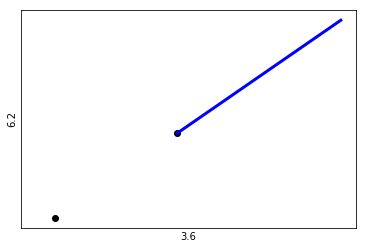

[1.88 1.8]
[1.8 1.7399999999999998]


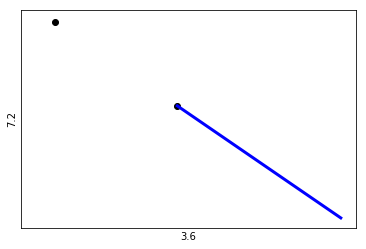

[1.7399999999999998]
[]
[1.88 1.8]
[1.8]
[1.88 1.8]
[1.8 1.7399999999999998]


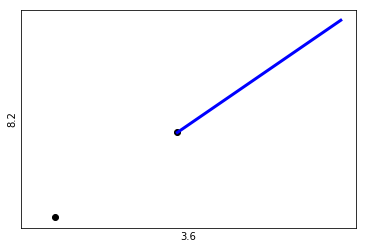

[1.88 1.8]
[1.8 1.7399999999999998]


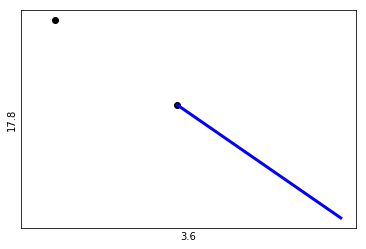

[1.88 1.8]
[1.8 1.7399999999999998]


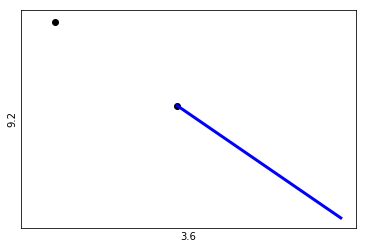

[1.88 1.8]
[1.8 1.7399999999999998]


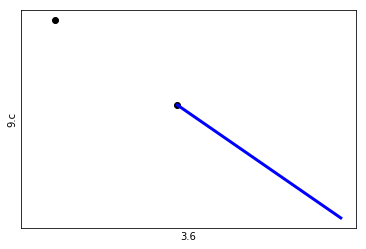

[27037740000.0 30450360000.0]
[23144470000.0 32129370000.0]


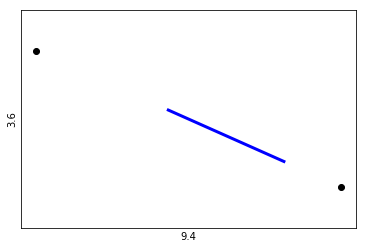

[24932650000.0 32381040000.0 27037740000.0 23884090000.0 31592910000.0
 28989750000.0 23481980000.0 31354390000.0 30450360000.0 27890300000.0]
[26110250000.0 28748570000.0 23144470000.0 29164800000.0 32129370000.0]


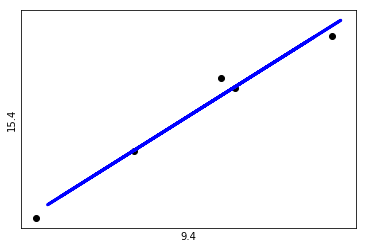

[27037740000.0 30450360000.0]
[23144470000.0]
[29164800000.0 32129370000.0 31354390000.0 27890300000.0]
[26110250000.0 28748570000.0 23144470000.0]


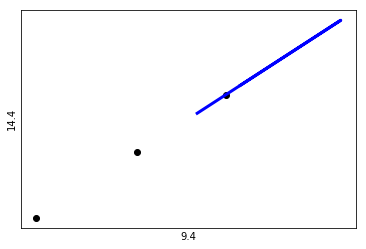

[27037740000.0 30450360000.0]
[23144470000.0 32381040000.0]


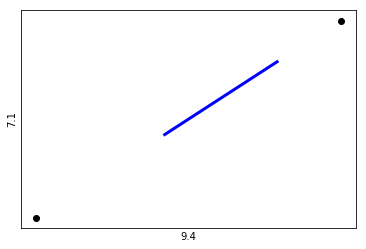

[24932650000.0 32381040000.0 27037740000.0 23884090000.0 31592910000.0
 28989750000.0 23481980000.0 31354390000.0 30450360000.0 27890300000.0]
[26110250000.0 28748570000.0 23144470000.0 29164800000.0 32129370000.0]


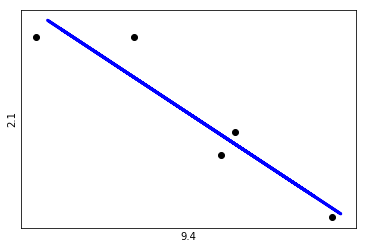

[24932650000.0 32381040000.0 27037740000.0 23884090000.0 31592910000.0
 28989750000.0 23481980000.0 31354390000.0 30450360000.0 27890300000.0]
[26110250000.0 28748570000.0 23144470000.0 29164800000.0 32129370000.0]


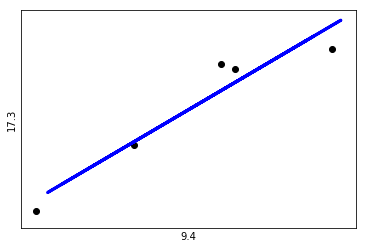

[30450360000.0]
[32381040000.0]
[27037740000.0 30450360000.0]
[23144470000.0]
[24932650000.0 32381040000.0 27037740000.0 23884090000.0 31592910000.0
 28989750000.0 23481980000.0 31354390000.0 30450360000.0 27890300000.0]
[26110250000.0 28748570000.0 23144470000.0 29164800000.0 32129370000.0]


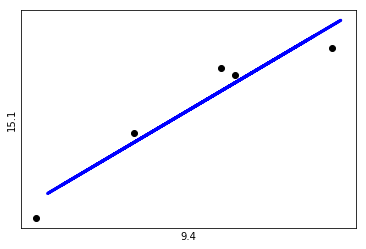

[27037740000.0 30450360000.0]
[23144470000.0]
[32381040000.0 31592910000.0 28989750000.0 31354390000.0 30450360000.0
 27890300000.0]
[28748570000.0 29164800000.0 32129370000.0]


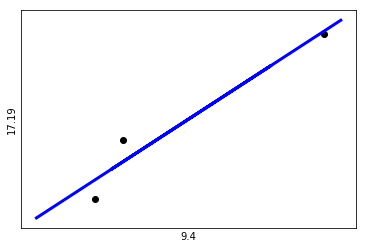

[24932650000.0 32381040000.0 27037740000.0 31592910000.0 28989750000.0
 31354390000.0 30450360000.0 27890300000.0]
[26110250000.0 28748570000.0 29164800000.0 32129370000.0]


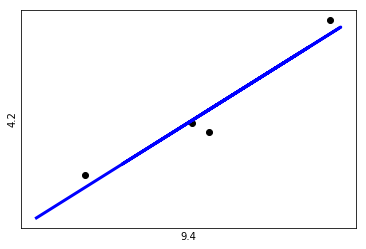

[24932650000.0 32381040000.0 27037740000.0 23884090000.0 31592910000.0
 28989750000.0 23481980000.0 31354390000.0 30450360000.0 27890300000.0]
[26110250000.0 28748570000.0 23144470000.0 29164800000.0 32129370000.0]


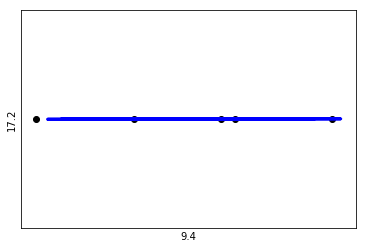

[24932650000.0 32381040000.0 27037740000.0 23884090000.0 31592910000.0
 28989750000.0 23481980000.0 31354390000.0 30450360000.0 27890300000.0]
[26110250000.0 28748570000.0 23144470000.0 29164800000.0 32129370000.0]


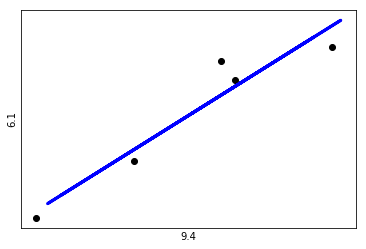

[27037740000.0 30450360000.0]
[23144470000.0]
[24932650000.0 27037740000.0 23884090000.0 28989750000.0 23481980000.0
 30450360000.0 27890300000.0]
[26110250000.0 28748570000.0 23144470000.0 29164800000.0]


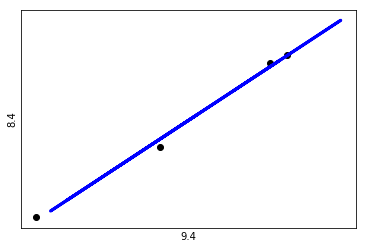

[24932650000.0 32381040000.0 27037740000.0 23884090000.0 31592910000.0
 28989750000.0 23481980000.0 31354390000.0 30450360000.0 27890300000.0]
[26110250000.0 28748570000.0 23144470000.0 29164800000.0 32129370000.0]


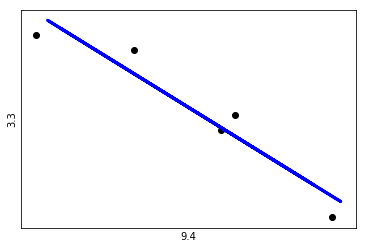

[24932650000.0 27037740000.0 23884090000.0 28989750000.0 23481980000.0
 30450360000.0 27890300000.0]
[26110250000.0 28748570000.0 23144470000.0 29164800000.0]


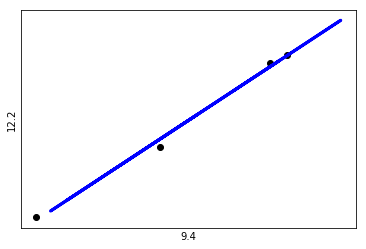

[32129370000.0]
[]
[32381040000.0]
[]
[24932650000.0 32381040000.0 27037740000.0 23884090000.0 31592910000.0
 28989750000.0 23481980000.0 31354390000.0 30450360000.0 27890300000.0]
[26110250000.0 28748570000.0 23144470000.0 29164800000.0 32129370000.0]


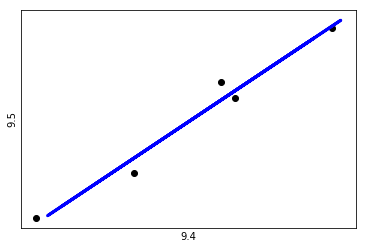

[27037740000.0]
[]
[24932650000.0 32381040000.0 27037740000.0 23884090000.0 31592910000.0
 28989750000.0 23481980000.0 31354390000.0 30450360000.0 27890300000.0]
[26110250000.0 28748570000.0 23144470000.0 29164800000.0 32129370000.0]


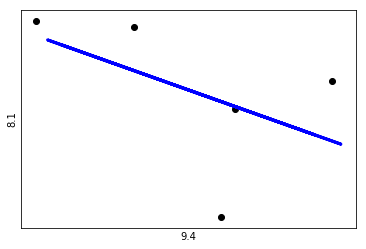

[32.149999999999999 24.73 30.969999999999999 32.719999999999999 26.23 29.66
 33.270000000000003 26.969999999999999 27.579999999999998 30.32]
[31.579999999999998 28.289999999999999 33.759999999999998 28.98 25.48]


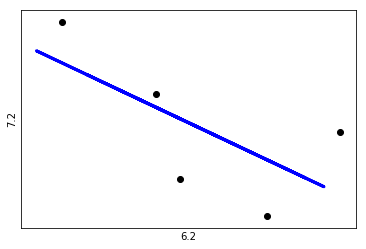

[23.969999999999999 26.23 26.969999999999999]
[25.48 24.73]


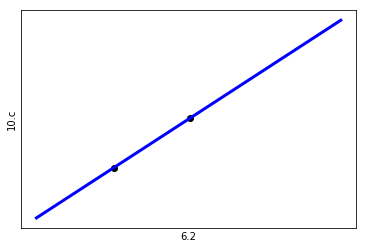

[23.969999999999999 27.579999999999998]
[33.759999999999998 30.969999999999999]


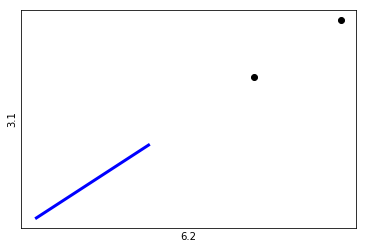

[24.73 30.969999999999999 23.969999999999999 32.719999999999999 26.23 29.66
 33.270000000000003 26.969999999999999 27.579999999999998 30.32]
[31.579999999999998 28.289999999999999 33.759999999999998 28.98 25.48
 32.149999999999999]


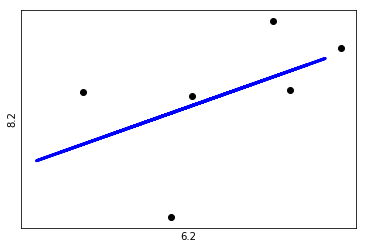

[24.73 30.969999999999999 23.969999999999999 32.719999999999999 26.23 29.66
 33.270000000000003 26.969999999999999 27.579999999999998 30.32]
[31.579999999999998 28.289999999999999 33.759999999999998 28.98 25.48
 32.149999999999999]


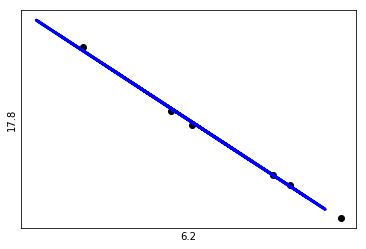

[24.73 30.969999999999999 23.969999999999999 32.719999999999999 26.23 29.66
 33.270000000000003 26.969999999999999 27.579999999999998 30.32]
[31.579999999999998 28.289999999999999 33.759999999999998 28.98 25.48
 32.149999999999999]


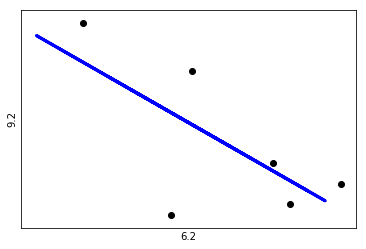

[24.73 30.969999999999999 23.969999999999999 32.719999999999999 26.23 29.66
 33.270000000000003 26.969999999999999 27.579999999999998 30.32]
[31.579999999999998 28.289999999999999 33.759999999999998 28.98 25.48
 32.149999999999999]


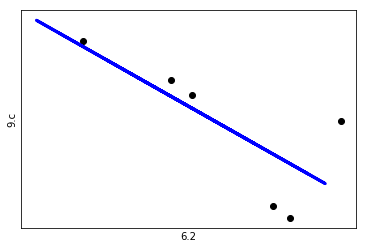

[24932650000.0 32381040000.0 27037740000.0 23884090000.0 31592910000.0
 28989750000.0 23481980000.0 31354390000.0 30450360000.0 27890300000.0]
[26110250000.0 28748570000.0 23144470000.0 29164800000.0 32129370000.0]


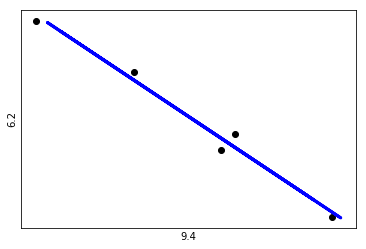

[17.91 17.54]
[18.19 18.33]


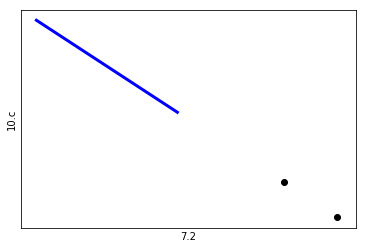

[16.91 17.51]
[17.45]
[17.16 18.33 16.91 17.29 17.91 16.91 17.28 17.54 17.51 16.97]
[16.89 17.71 17.45 17.14 18.19]


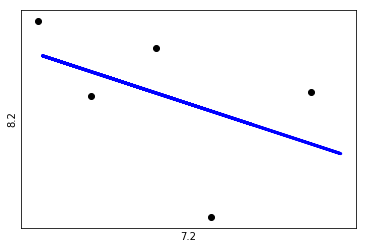

[17.16 18.33 16.91 17.29 17.91 16.91 17.28 17.54 17.51 16.97]
[16.89 17.71 17.45 17.14 18.19]


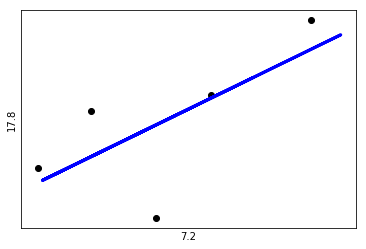

[17.16 18.33 16.91 17.29 17.91 16.91 17.28 17.54 17.51 16.97]
[16.89 17.71 17.45 17.14 18.19]


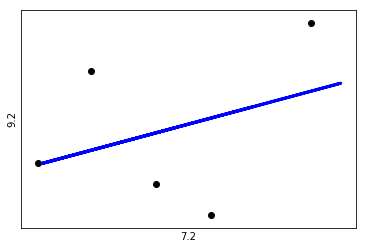

[17.16 18.33 16.91 17.29 17.91 16.91 17.28 17.54 17.51 16.97]
[16.89 17.71 17.45 17.14 18.19]


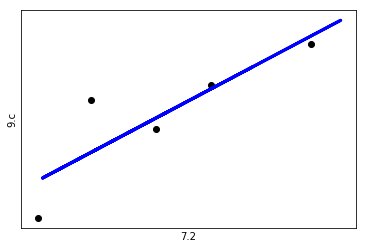

[24932650000.0 32381040000.0 27037740000.0 23884090000.0 31592910000.0
 28989750000.0 23481980000.0 31354390000.0 30450360000.0 27890300000.0]
[26110250000.0 28748570000.0 23144470000.0 29164800000.0 32129370000.0]


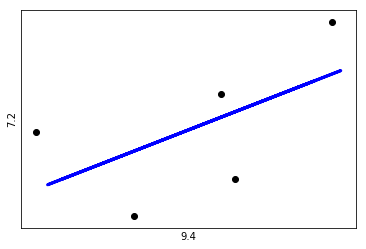

[7.5]
[]
[7.5 9.0 8.9]
[8.6 8.2]


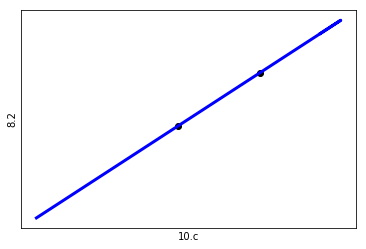

[7.5 9.0 8.9]
[8.6 8.2]


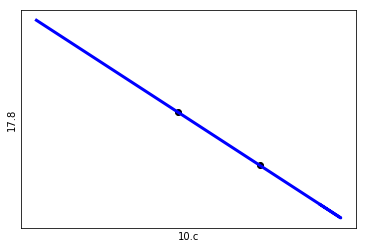

[7.5 9.0 8.9]
[8.6 8.2]


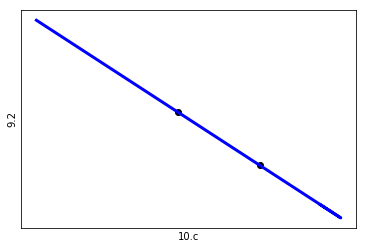

[7.5 9.0 8.9]
[8.6 8.2]


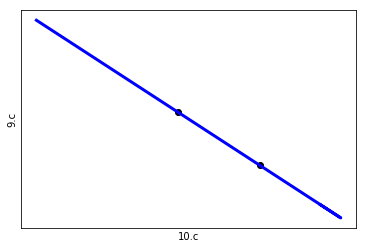

[31592910000.0 31354390000.0]
[32129370000.0 32381040000.0]


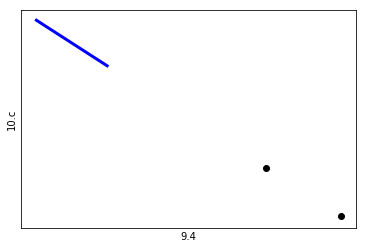

[21.600000000000001 24.600000000000001]
[34.100000000000001 28.800000000000001]


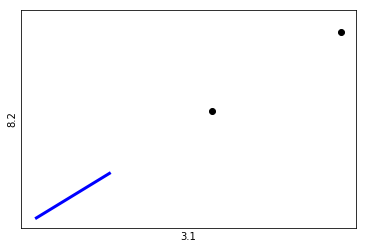

[21.600000000000001 24.600000000000001]
[34.100000000000001 28.800000000000001]


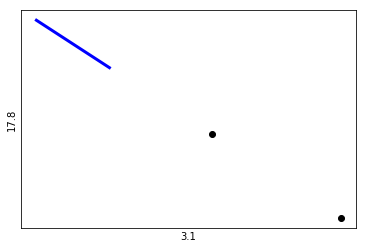

[21.600000000000001 24.600000000000001]
[34.100000000000001 28.800000000000001]


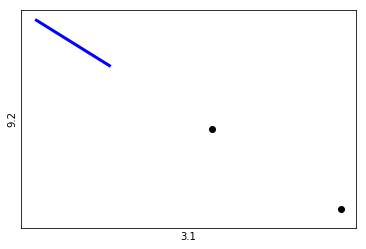

[21.600000000000001 24.600000000000001]
[34.100000000000001 28.800000000000001]


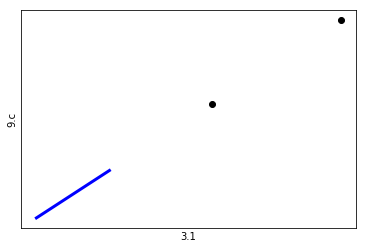

[27037740000.0 30450360000.0]
[23144470000.0]
[1.8 2.77 1.67 1.45 1.9 3.79 0.89 2.66 4.07 3.85]
[3.42 -0.71 2.86 1.83 1.93 1.97]


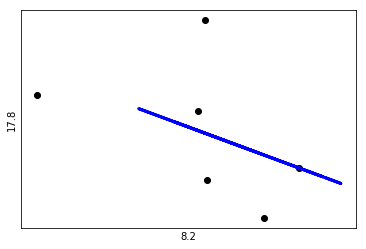

[1.8 2.77 1.67 1.45 1.9 3.79 0.89 2.66 4.07 1.8 3.85]
[3.42 -0.71 2.86 1.83 1.93 1.97]


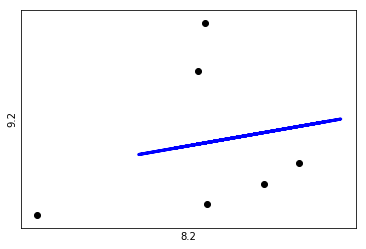

[1.8 2.77 1.67 1.45 1.9 3.79 0.89 2.66 4.07 3.85]
[3.42 -0.71 2.86 1.83 1.93 1.97]


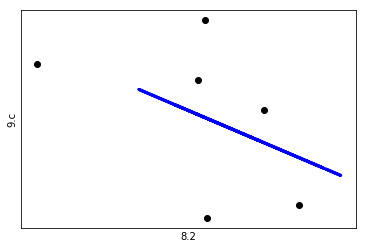

[24932650000.0 32381040000.0 27037740000.0 23884090000.0 31592910000.0
 28989750000.0 23481980000.0 31354390000.0 30450360000.0 27890300000.0]
[26110250000.0 28748570000.0 23144470000.0 29164800000.0 32129370000.0]


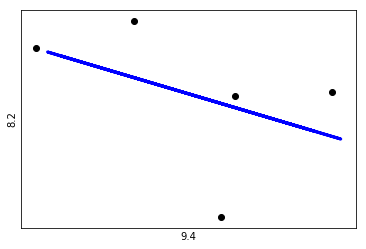

[40.490000000000002 15.76 43.75 10.710000000000001 34.799999999999997
 20.539999999999999 8.0999999999999996 31.690000000000001
 29.109999999999999 17.460000000000001]
[14.26 25.66 6.5599999999999996 23.18 37.18 12.369999999999999]


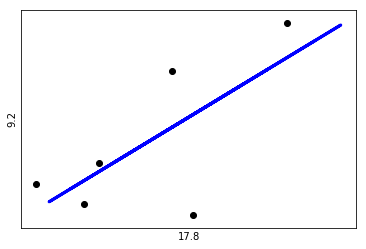

[40.490000000000002 15.76 43.75 10.710000000000001 34.799999999999997
 20.539999999999999 8.0999999999999996 31.690000000000001
 29.109999999999999 17.460000000000001]
[14.26 25.66 6.5599999999999996 23.18 37.18 12.369999999999999]


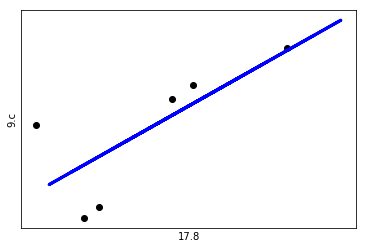

[24932650000.0 32381040000.0 27037740000.0 23884090000.0 31592910000.0
 28989750000.0 23481980000.0 31354390000.0 30450360000.0 27890300000.0]
[26110250000.0 28748570000.0 23144470000.0 29164800000.0 32129370000.0]


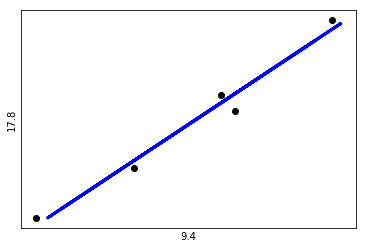

[16.030000000000001 15.279999999999999 16.109999999999999 14.81 15.94 15.84
 14.869999999999999 15.970000000000001 15.81 15.609999999999999]
[15.26 14.99 15.15 15.74 15.99 15.050000000000001]


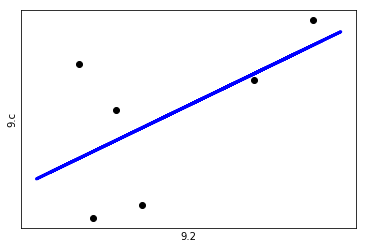

[24932650000.0 32381040000.0 27037740000.0 23884090000.0 31592910000.0
 28989750000.0 23481980000.0 31354390000.0 30450360000.0 27890300000.0]
[26110250000.0 28748570000.0 23144470000.0 29164800000.0 32129370000.0]


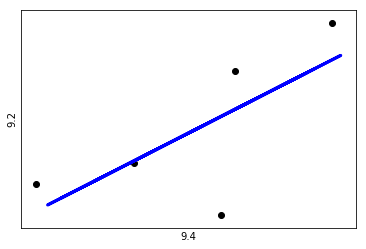

[24932650000.0 32381040000.0 27037740000.0 23884090000.0 31592910000.0
 28989750000.0 23481980000.0 31354390000.0 30450360000.0 27890300000.0]
[26110250000.0 28748570000.0 23144470000.0 29164800000.0 32129370000.0]


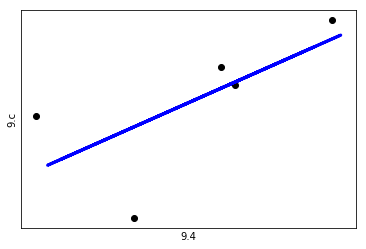

[42.920000000000002 46.990000000000002]
[38.789999999999999 48.82]


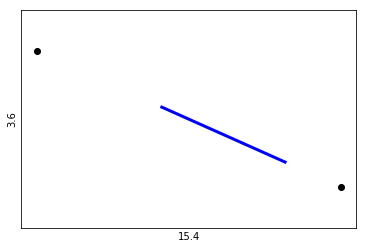

[48.990000000000002 42.920000000000002 49.030000000000001
 40.719999999999999 48.409999999999997 45.240000000000002
 39.950000000000003 47.549999999999997 46.990000000000002
 44.140000000000001]
[42.460000000000001 46.509999999999998 38.789999999999999
 45.950000000000003 48.82 41.079999999999998]


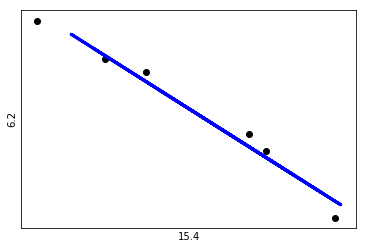

[41.079999999999998 48.990000000000002 42.920000000000002
 40.719999999999999 48.409999999999997 45.240000000000002
 39.950000000000003 47.549999999999997 46.990000000000002
 44.140000000000001]
[42.460000000000001 46.509999999999998 38.789999999999999
 45.950000000000003 48.82]


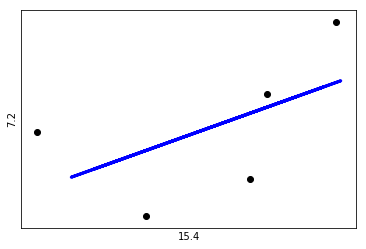

[49.030000000000001 48.409999999999997 47.549999999999997]
[48.82 48.990000000000002]


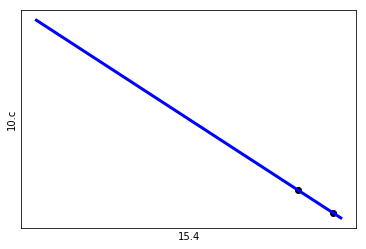

[49.030000000000001 46.990000000000002]
[38.789999999999999 42.920000000000002]


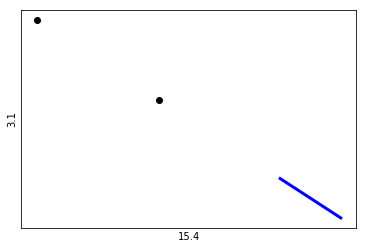

[48.990000000000002 42.920000000000002 49.030000000000001
 40.719999999999999 48.409999999999997 45.240000000000002
 39.950000000000003 47.549999999999997 46.990000000000002
 49.060000000000002 44.140000000000001]
[42.460000000000001 46.509999999999998 38.789999999999999
 45.950000000000003 48.82 41.079999999999998]


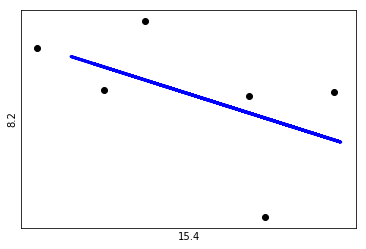

[48.990000000000002 42.920000000000002 49.030000000000001
 40.719999999999999 48.409999999999997 45.240000000000002
 39.950000000000003 47.549999999999997 46.990000000000002
 44.140000000000001]
[42.460000000000001 46.509999999999998 38.789999999999999
 45.950000000000003 48.82 41.079999999999998]


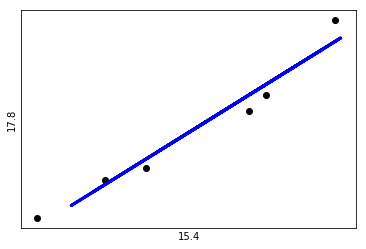

[48.990000000000002 42.920000000000002 49.030000000000001
 40.719999999999999 48.409999999999997 45.240000000000002
 39.950000000000003 47.549999999999997 46.990000000000002
 49.060000000000002 44.140000000000001]
[42.460000000000001 46.509999999999998 38.789999999999999
 45.950000000000003 48.82 41.079999999999998]


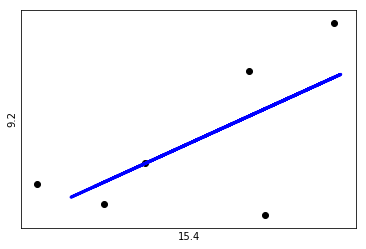

[48.990000000000002 42.920000000000002 49.030000000000001
 40.719999999999999 48.409999999999997 45.240000000000002
 39.950000000000003 47.549999999999997 46.990000000000002
 44.140000000000001]
[42.460000000000001 46.509999999999998 38.789999999999999
 45.950000000000003 48.82 41.079999999999998]


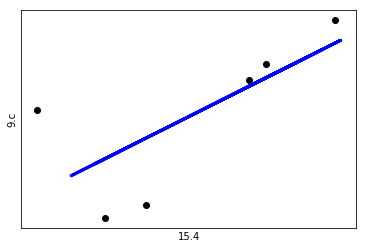

[49.030000000000001 46.990000000000002 49.060000000000002]
[38.789999999999999 42.920000000000002]


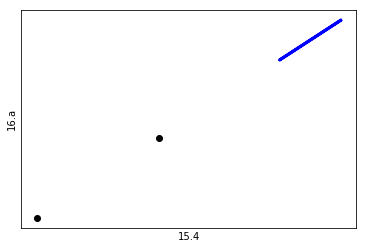

[45.950000000000003 48.82 47.549999999999997 44.140000000000001]
[42.460000000000001 46.509999999999998 38.789999999999999]


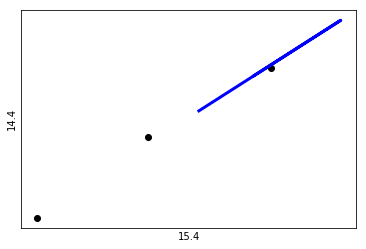

[42.920000000000002 46.990000000000002]
[38.789999999999999 48.990000000000002]


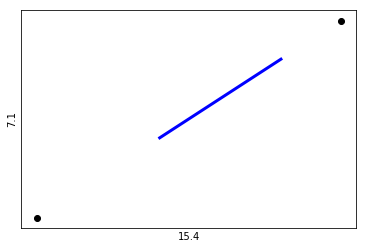

[48.990000000000002 42.920000000000002 49.030000000000001
 40.719999999999999 48.409999999999997 45.240000000000002
 39.950000000000003 47.549999999999997 46.990000000000002
 44.140000000000001]
[42.460000000000001 46.509999999999998 38.789999999999999
 45.950000000000003 48.82 41.079999999999998]


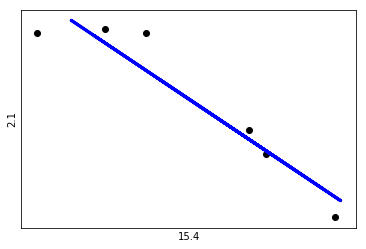

[48.990000000000002 42.920000000000002 49.030000000000001
 40.719999999999999 48.409999999999997 45.240000000000002
 39.950000000000003 47.549999999999997 46.990000000000002
 44.140000000000001]
[42.460000000000001 46.509999999999998 38.789999999999999
 45.950000000000003 48.82 41.079999999999998]


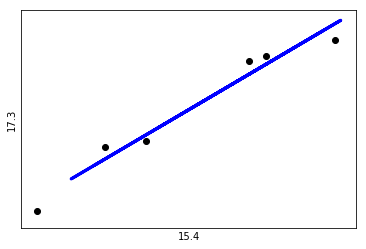

[46.990000000000002]
[48.990000000000002]
[49.030000000000001 46.990000000000002]
[38.789999999999999 42.920000000000002]


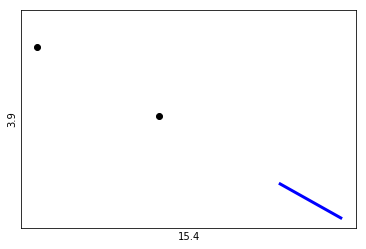

[41.079999999999998 48.990000000000002 42.920000000000002
 49.030000000000001 40.719999999999999 48.409999999999997
 45.240000000000002 39.950000000000003 47.549999999999997
 46.990000000000002 49.060000000000002 44.140000000000001]
[42.460000000000001 46.509999999999998 38.789999999999999
 45.950000000000003 49.060000000000002 48.82]


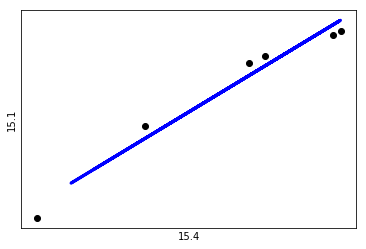

[49.030000000000001 46.990000000000002]
[38.789999999999999 42.920000000000002]


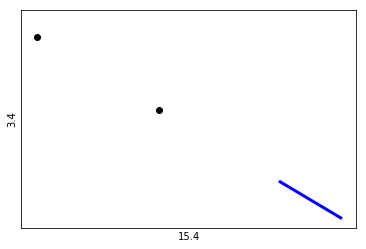

[48.990000000000002 48.409999999999997 45.240000000000002
 47.549999999999997 46.990000000000002 44.140000000000001]
[46.509999999999998 45.950000000000003 48.82]


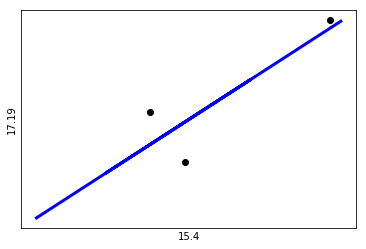

[41.079999999999998 48.990000000000002 42.920000000000002
 48.409999999999997 45.240000000000002 47.549999999999997
 46.990000000000002 44.140000000000001]
[42.460000000000001 46.509999999999998 45.950000000000003 48.82]


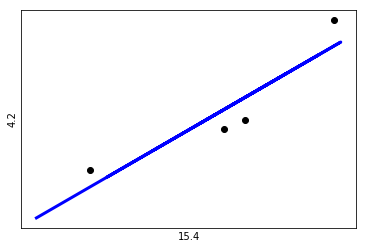

[48.990000000000002 42.920000000000002 49.030000000000001
 40.719999999999999 48.409999999999997 45.240000000000002
 39.950000000000003 47.549999999999997 46.990000000000002
 49.060000000000002 44.140000000000001]
[42.460000000000001 46.509999999999998 38.789999999999999
 45.950000000000003 48.82 41.079999999999998]


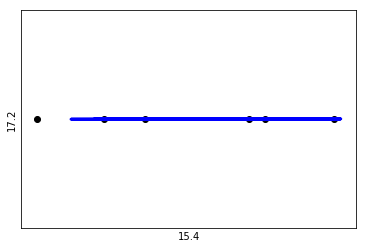

[48.990000000000002 42.920000000000002 49.030000000000001
 40.719999999999999 48.409999999999997 45.240000000000002
 39.950000000000003 47.549999999999997 46.990000000000002
 44.140000000000001]
[42.460000000000001 46.509999999999998 38.789999999999999
 45.950000000000003 48.82 41.079999999999998]


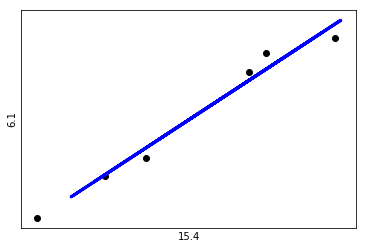

[49.030000000000001 46.990000000000002 49.060000000000002]
[38.789999999999999 42.920000000000002]


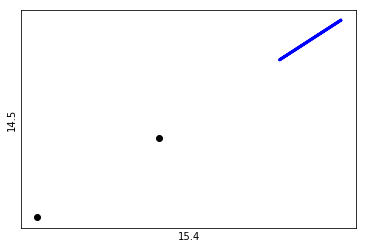

[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


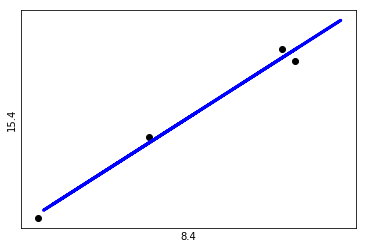

[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


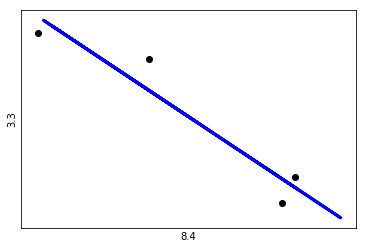

[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


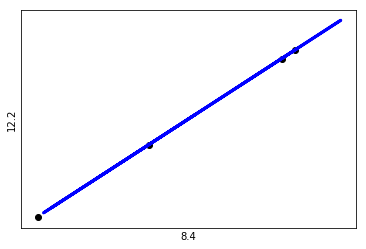

[]
[]
[]
[]
[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


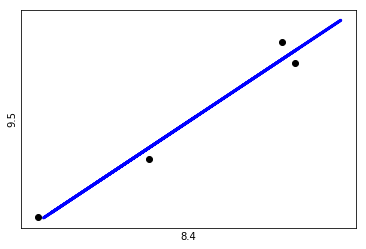

[9.0999999999999996]
[]
[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


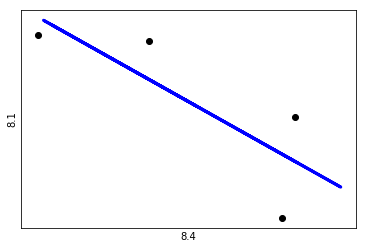

[27.899999999999999 32.899999999999999]
[16.199999999999999]
[35.5 32.899999999999999]
[16.199999999999999 27.899999999999999]


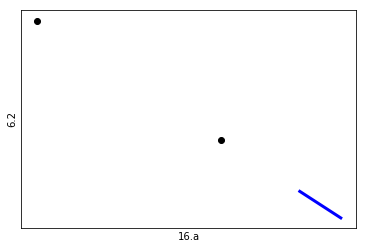

[27.899999999999999 32.899999999999999]
[16.199999999999999]
[35.5]
[]
[35.5 32.899999999999999]
[16.199999999999999 27.899999999999999]


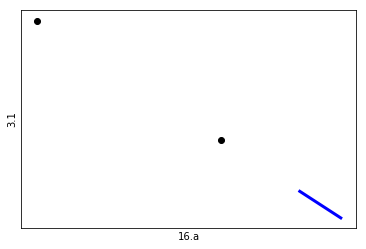

[35.5 32.899999999999999 36.5]
[16.199999999999999 27.899999999999999]


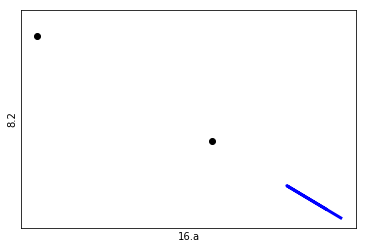

[35.5 32.899999999999999]
[16.199999999999999 27.899999999999999]


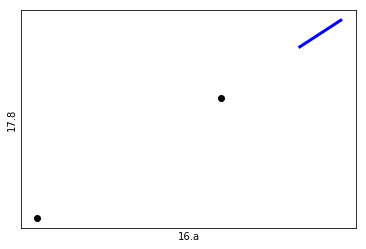

[35.5 32.899999999999999 36.5]
[16.199999999999999 27.899999999999999]


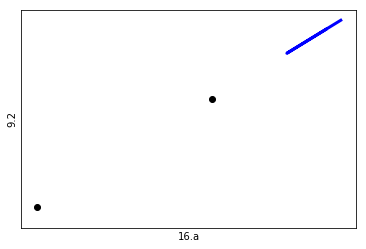

[35.5 32.899999999999999]
[16.199999999999999 27.899999999999999]


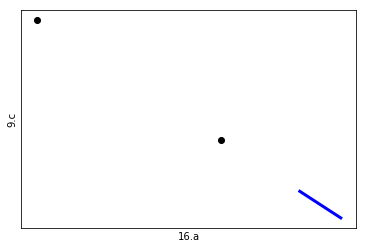

[16.199999999999999]
[]
[27.899999999999999 32.899999999999999]
[16.199999999999999]
[35.5 32.899999999999999]
[16.199999999999999 27.899999999999999]


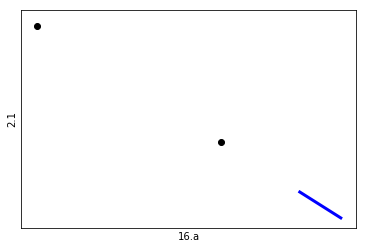

[35.5 32.899999999999999]
[16.199999999999999 27.899999999999999]


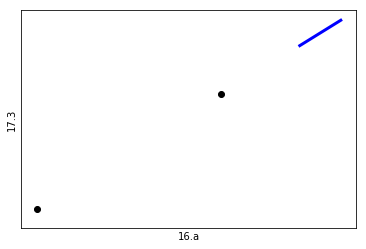

[32.899999999999999]
[]
[35.5 32.899999999999999]
[16.199999999999999 27.899999999999999]


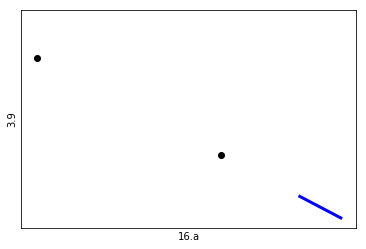

[35.5 32.899999999999999 36.5]
[16.199999999999999 27.899999999999999]


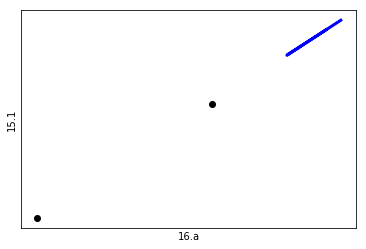

[35.5 32.899999999999999]
[16.199999999999999 27.899999999999999]


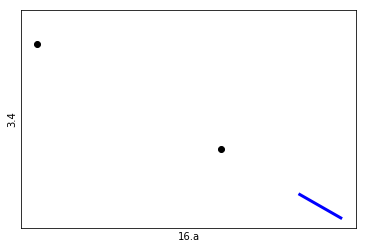

[32.899999999999999]
[]
[32.899999999999999]
[27.899999999999999]
[35.5 32.899999999999999 36.5]
[16.199999999999999 27.899999999999999]


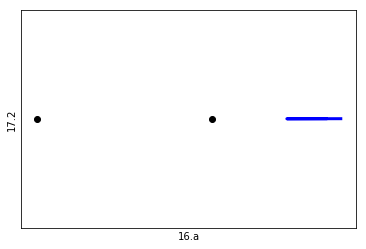

[35.5 32.899999999999999]
[16.199999999999999 27.899999999999999]


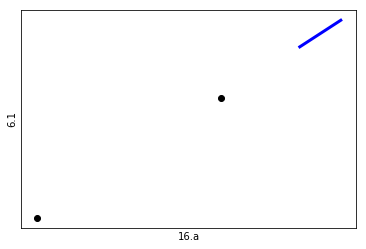

[35.5 32.899999999999999 36.5]
[16.199999999999999 27.899999999999999]


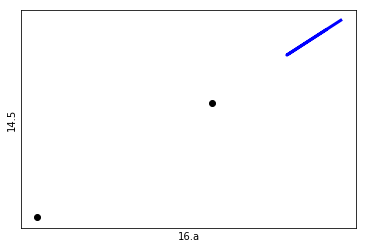

[9.0999999999999996 10.1]
[8.0]
[58.109999999999999]
[47.170000000000002]
[52.829999999999998 58.109999999999999 61.280000000000001
 51.509999999999998]
[52.710000000000001 57.469999999999999 47.170000000000002]


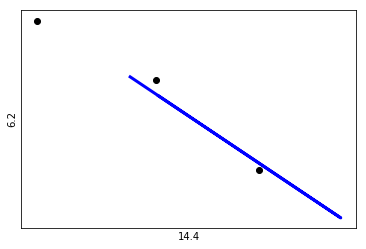

[52.829999999999998 58.109999999999999 61.280000000000001
 51.509999999999998]
[52.710000000000001 57.469999999999999 47.170000000000002]


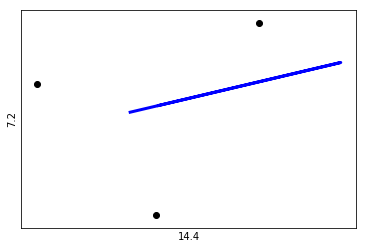

[61.280000000000001]
[58.109999999999999]
[47.170000000000002]
[]
[52.829999999999998 58.109999999999999 61.280000000000001
 51.509999999999998]
[52.710000000000001 57.469999999999999 47.170000000000002]


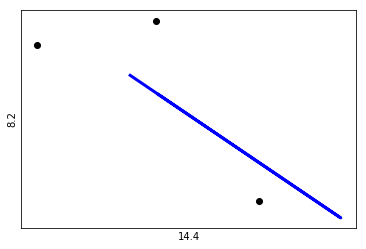

[52.829999999999998 58.109999999999999 61.280000000000001
 51.509999999999998]
[52.710000000000001 57.469999999999999 47.170000000000002]


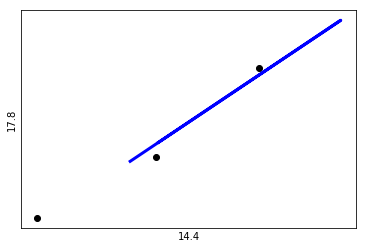

[52.829999999999998 58.109999999999999 61.280000000000001
 51.509999999999998]
[52.710000000000001 57.469999999999999 47.170000000000002]


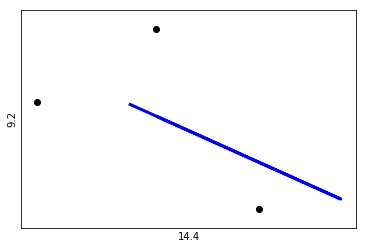

[52.829999999999998 58.109999999999999 61.280000000000001
 51.509999999999998]
[52.710000000000001 57.469999999999999 47.170000000000002]


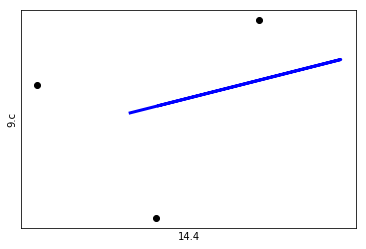

[47.170000000000002]
[]
[58.109999999999999 43.350000000000001 45.950000000000003
 49.729999999999997 61.280000000000001 51.509999999999998]
[52.710000000000001 57.469999999999999 47.170000000000002
 52.829999999999998]


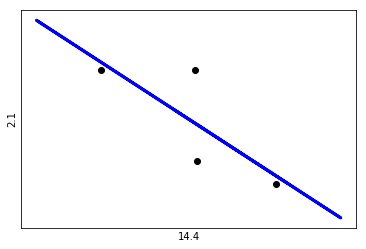

[52.829999999999998 58.109999999999999 61.280000000000001
 51.509999999999998]
[52.710000000000001 57.469999999999999 47.170000000000002]


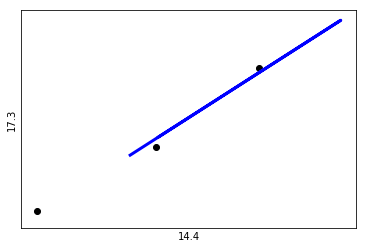

[]
[]
[47.170000000000002]
[]
[52.829999999999998 58.109999999999999 61.280000000000001
 51.509999999999998]
[52.710000000000001 57.469999999999999 47.170000000000002]


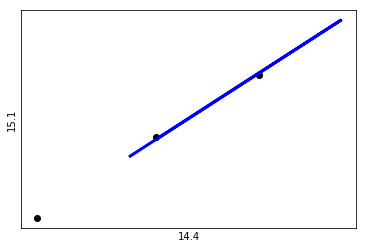

[47.170000000000002]
[]
[58.109999999999999 61.280000000000001 51.509999999999998]
[57.469999999999999 52.829999999999998]


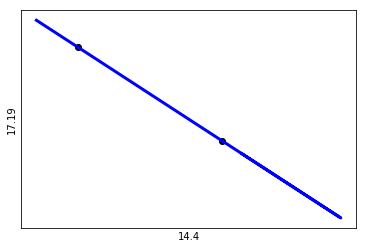

[52.829999999999998 58.109999999999999 61.280000000000001
 51.509999999999998]
[52.710000000000001 57.469999999999999]


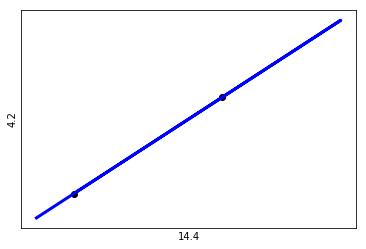

[52.829999999999998 58.109999999999999 61.280000000000001
 51.509999999999998]
[52.710000000000001 57.469999999999999 47.170000000000002]


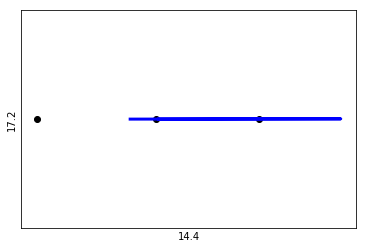

[52.829999999999998 58.109999999999999 61.280000000000001
 51.509999999999998]
[52.710000000000001 57.469999999999999 47.170000000000002]


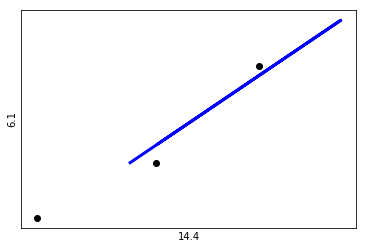

[47.170000000000002]
[]
[8.0 9.7799999999999994 9.4199999999999999]
[8.7699999999999996 9.6899999999999995]


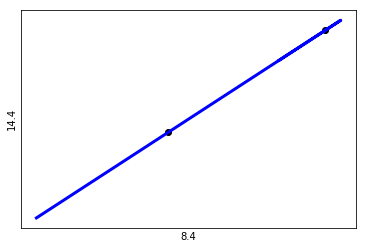

[66.090000000000003 70.200000000000003]
[63.149999999999999]
[66.090000000000003 70.200000000000003]
[63.149999999999999 73.040000000000006]


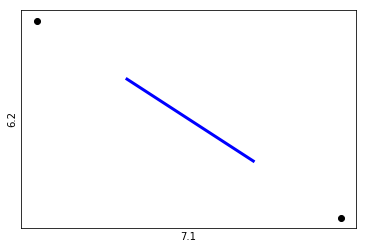

[66.090000000000003 70.200000000000003]
[63.149999999999999 73.040000000000006]


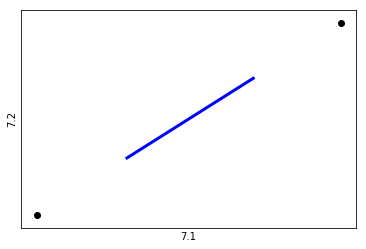

[73.040000000000006]
[]
[66.090000000000003 70.200000000000003]
[63.149999999999999]
[66.090000000000003 70.200000000000003]
[63.149999999999999 73.040000000000006]


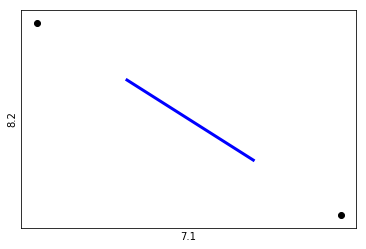

[66.090000000000003 70.200000000000003]
[63.149999999999999 73.040000000000006]


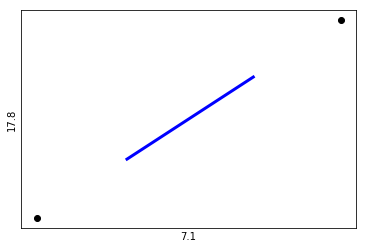

[66.090000000000003 70.200000000000003]
[63.149999999999999 73.040000000000006]


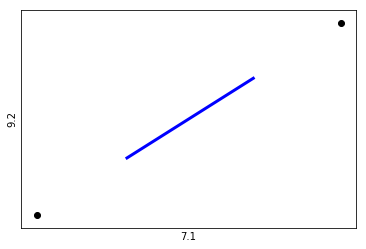

[66.090000000000003 70.200000000000003]
[63.149999999999999 73.040000000000006]


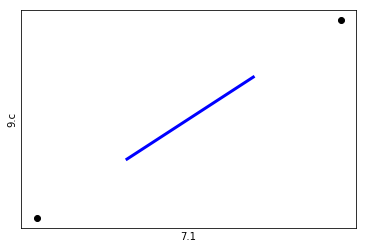

[66.090000000000003 70.200000000000003]
[63.149999999999999 73.040000000000006]


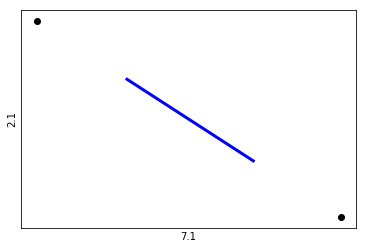

[66.090000000000003 70.200000000000003]
[63.149999999999999 73.040000000000006]


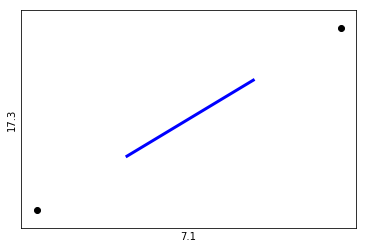

[70.200000000000003]
[73.040000000000006]
[66.090000000000003 70.200000000000003]
[63.149999999999999]
[66.090000000000003 70.200000000000003]
[63.149999999999999 73.040000000000006]


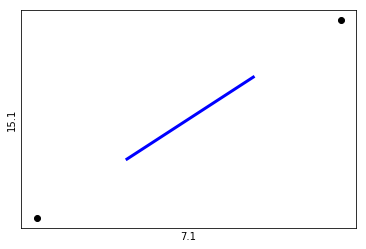

[66.090000000000003 70.200000000000003]
[63.149999999999999]
[70.200000000000003]
[73.040000000000006]
[66.090000000000003 70.200000000000003]
[73.040000000000006]
[66.090000000000003 70.200000000000003]
[63.149999999999999 73.040000000000006]


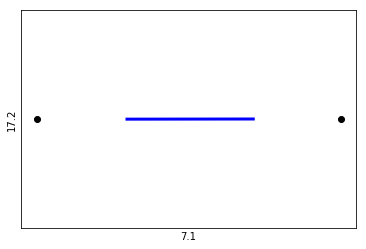

[66.090000000000003 70.200000000000003]
[63.149999999999999 73.040000000000006]


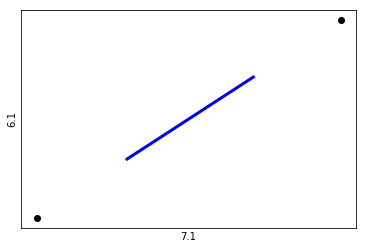

[66.090000000000003 70.200000000000003]
[63.149999999999999]
[9.0999999999999996 10.1]
[8.0]
[14.699999999999999 12.1]
[15.0 11.199999999999999]


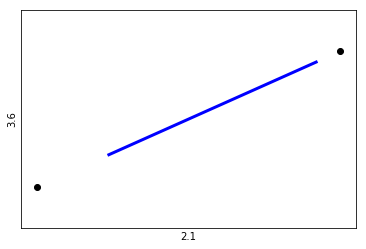

[11.0 14.699999999999999 10.800000000000001 15.0 11.4 13.699999999999999
 14.9 11.800000000000001 12.1 14.300000000000001]
[15.0 12.5 15.0 13.0 11.199999999999999 15.1]


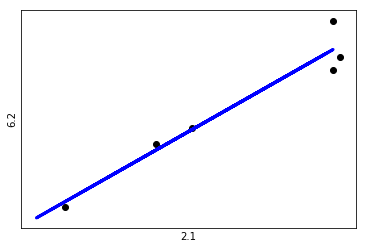

[15.1 11.0 14.699999999999999 15.0 11.4 13.699999999999999 14.9
 11.800000000000001 12.1 14.300000000000001]
[15.0 12.5 15.0 13.0 11.199999999999999]


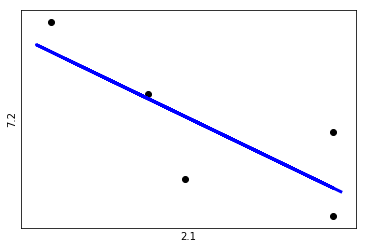

[10.800000000000001 11.4 11.800000000000001]
[11.199999999999999 11.0]


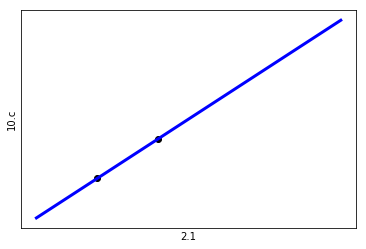

[10.800000000000001 12.1]
[15.0 14.699999999999999]


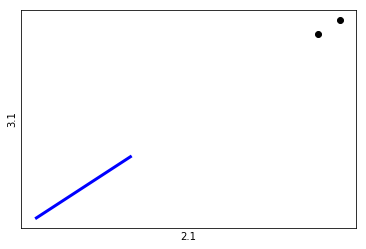

[11.0 14.699999999999999 10.800000000000001 15.0 11.4 13.699999999999999
 14.9 11.800000000000001 12.1 14.300000000000001]
[15.0 12.5 15.0 13.0 11.199999999999999 15.1]


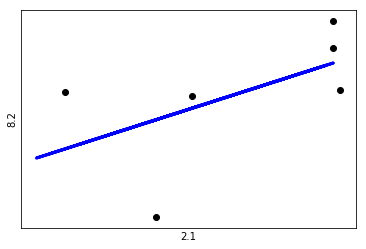

[11.0 14.699999999999999 10.800000000000001 15.0 11.4 13.699999999999999
 14.9 11.800000000000001 12.1 14.300000000000001]
[15.0 12.5 15.0 13.0 11.199999999999999 15.1]


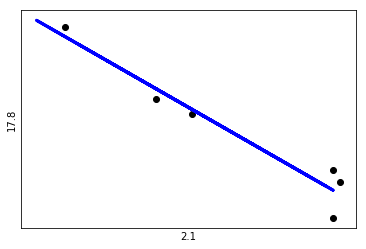

[11.0 14.699999999999999 10.800000000000001 15.0 11.4 13.699999999999999
 14.9 11.800000000000001 12.1 14.300000000000001]
[15.0 12.5 15.0 13.0 11.199999999999999 15.1]


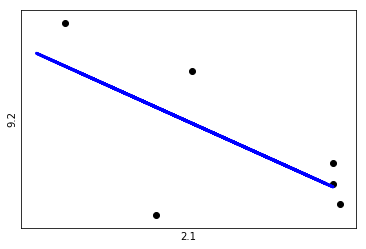

[11.0 14.699999999999999 10.800000000000001 15.0 11.4 13.699999999999999
 14.9 11.800000000000001 12.1 14.300000000000001]
[15.0 12.5 15.0 13.0 11.199999999999999 15.1]


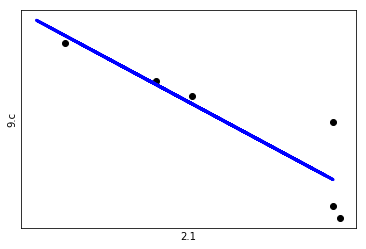

[11.0 14.699999999999999 10.800000000000001 15.0 11.4 13.699999999999999
 14.9 11.800000000000001 12.1 14.300000000000001]
[15.0 12.5 15.0 13.0 11.199999999999999 15.1]


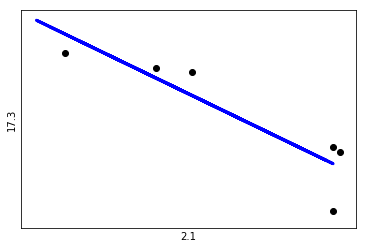

[12.1]
[11.0]
[10.800000000000001 12.1]
[15.0 14.699999999999999]


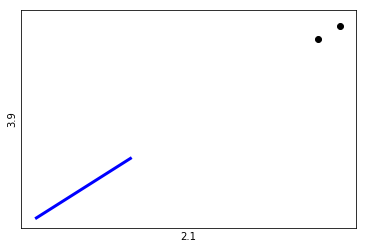

[11.0 14.699999999999999 10.800000000000001 15.0 11.4 13.699999999999999
 14.9 11.800000000000001 12.1 14.300000000000001]
[15.0 12.5 15.0 13.0 11.199999999999999 15.1]


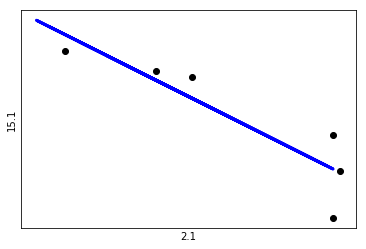

[10.800000000000001 12.1]
[15.0 14.699999999999999]


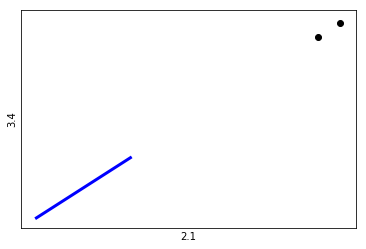

[11.0 11.4 13.699999999999999 11.800000000000001 12.1 14.300000000000001]
[12.5 13.0 11.199999999999999]


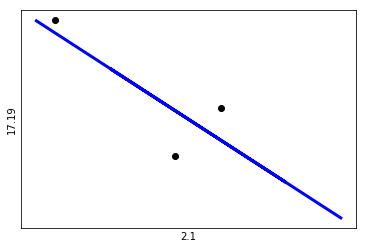

[15.1 11.0 14.699999999999999 11.4 13.699999999999999 11.800000000000001
 12.1 14.300000000000001]
[15.0 12.5 13.0 11.199999999999999]


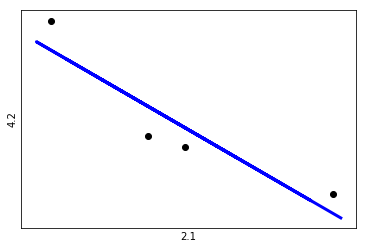

[11.0 14.699999999999999 10.800000000000001 15.0 11.4 13.699999999999999
 14.9 11.800000000000001 12.1 14.300000000000001]
[15.0 12.5 15.0 13.0 11.199999999999999 15.1]


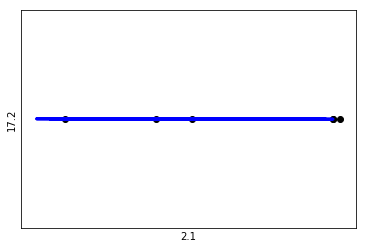

[11.0 14.699999999999999 10.800000000000001 15.0 11.4 13.699999999999999
 14.9 11.800000000000001 12.1 14.300000000000001]
[15.0 12.5 15.0 13.0 11.199999999999999 15.1]


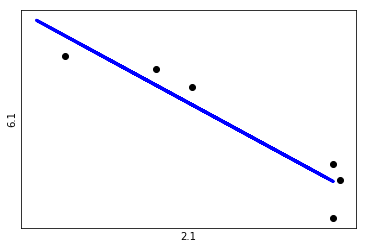

[10.800000000000001 12.1]
[15.0 14.699999999999999]


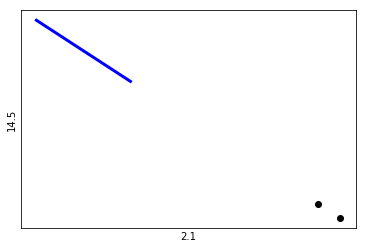

[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


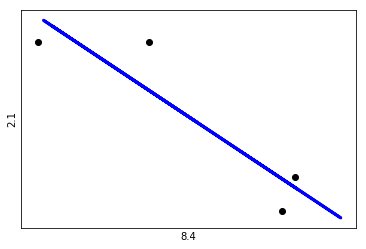

[0.54 0.65]
[0.37 0.69]


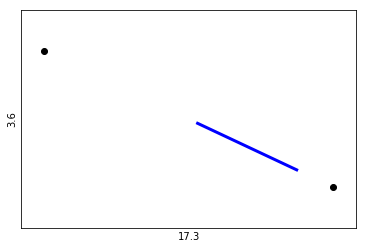

[0.71 0.54 0.76 0.45 0.67 0.62 0.41 0.65 0.65 0.58]
[0.5 0.66 0.37 0.65 0.69 0.49]


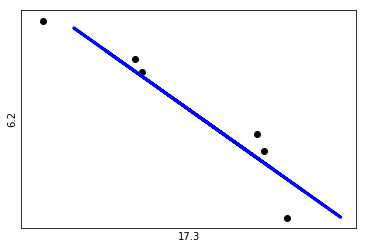

[0.49 0.71 0.54 0.45 0.67 0.62 0.41 0.65 0.65 0.58]
[0.5 0.66 0.37 0.65 0.69]


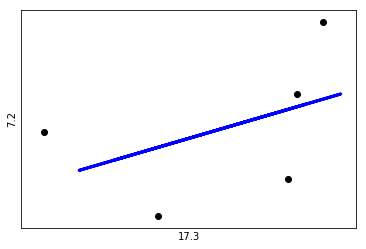

[0.76 0.67 0.65]
[0.69 0.71]


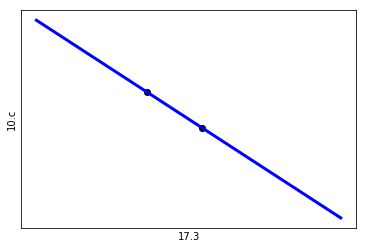

[0.76 0.65]
[0.37 0.54]


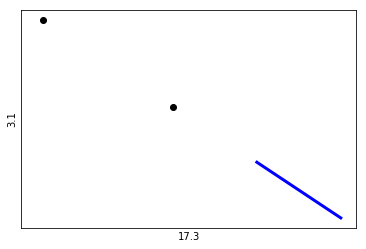

[0.71 0.54 0.76 0.45 0.67 0.62 0.41 0.65 0.65 0.58]
[0.5 0.66 0.37 0.65 0.69 0.49]


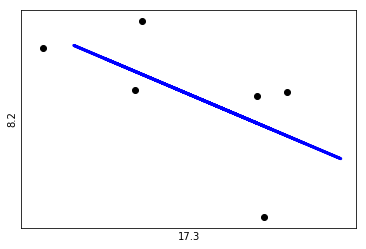

[0.71 0.54 0.76 0.45 0.67 0.62 0.41 0.65 0.65 0.58]
[0.5 0.66 0.37 0.65 0.69 0.49]


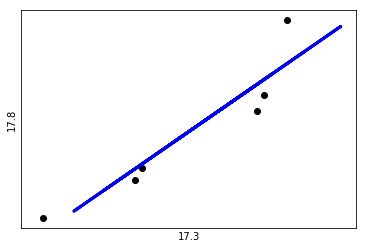

[0.71 0.54 0.76 0.45 0.67 0.62 0.41 0.65 0.65 0.58]
[0.5 0.66 0.37 0.65 0.69 0.49]


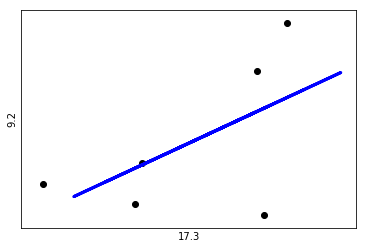

[0.71 0.54 0.76 0.45 0.67 0.62 0.41 0.65 0.65 0.58]
[0.5 0.66 0.37 0.65 0.69 0.49]


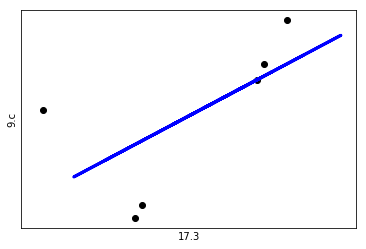

[0.65]
[0.71]
[0.76 0.65]
[0.37 0.54]


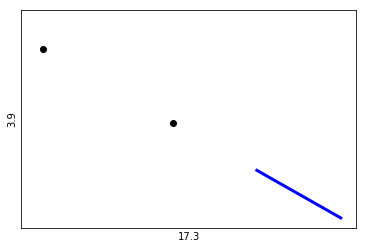

[0.71 0.54 0.76 0.45 0.67 0.62 0.41 0.65 0.65 0.58]
[0.5 0.66 0.37 0.65 0.69 0.49]


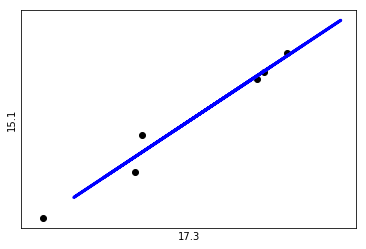

[0.76 0.65]
[0.37 0.54]


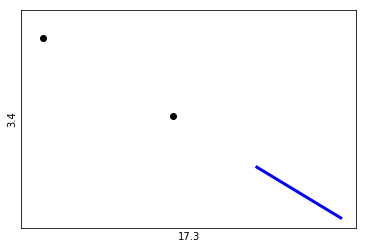

[0.71 0.67 0.62 0.65 0.65 0.58]
[0.66 0.65 0.69]


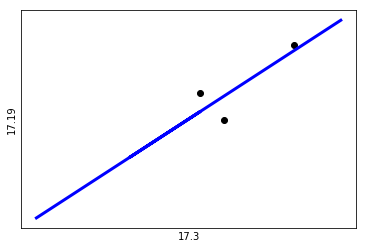

[0.49 0.71 0.54 0.67 0.62 0.65 0.65 0.58]
[0.5 0.66 0.65 0.69]


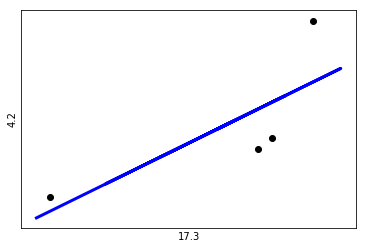

[0.71 0.54 0.76 0.45 0.67 0.62 0.41 0.65 0.65 0.58]
[0.5 0.66 0.37 0.65 0.69 0.49]


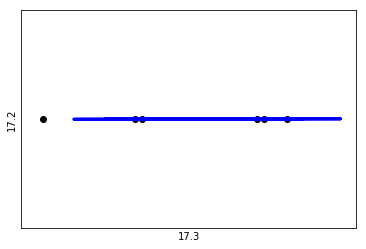

[0.71 0.54 0.76 0.45 0.67 0.62 0.41 0.65 0.65 0.58]
[0.5 0.66 0.37 0.65 0.69 0.49]


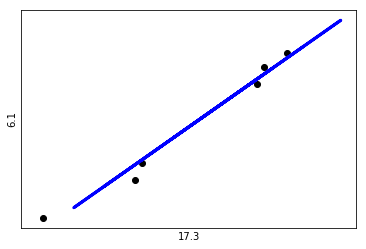

[0.76 0.65]
[0.37 0.54]


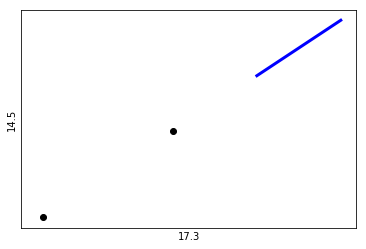

[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


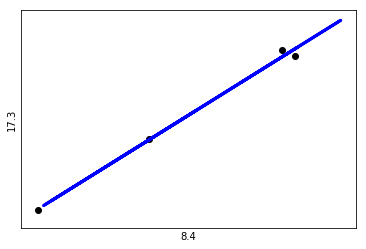

[7.0899999999999999]
[]
[7.0899999999999999]
[11.01]
[7.0899999999999999]
[11.01]
[11.01]
[]
[7.0899999999999999]
[]
[7.0899999999999999]
[11.01]
[7.0899999999999999]
[11.01]
[7.0899999999999999]
[11.01]
[7.0899999999999999]
[11.01]
[7.0899999999999999]
[]
[7.0899999999999999]
[11.01]
[7.0899999999999999]
[]
[7.0899999999999999]
[11.01]
[7.0899999999999999]
[11.01]
[7.0899999999999999]
[11.01]
[7.0899999999999999]
[11.01]
[7.0899999999999999]
[]
[10.1]
[]
[0.183 0.16]
[0.21800000000000005]
[0.147 0.16]
[0.21800000000000005 0.183]


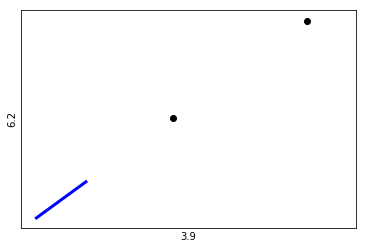

[0.183 0.16]
[0.21800000000000005]
[0.147]
[]
[0.147 0.16]
[0.21800000000000005 0.183]


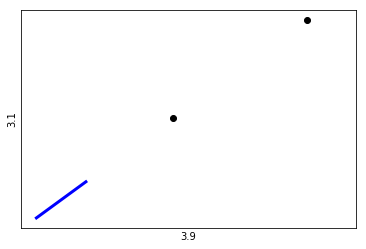

[0.147 0.16]
[0.21800000000000005 0.183]


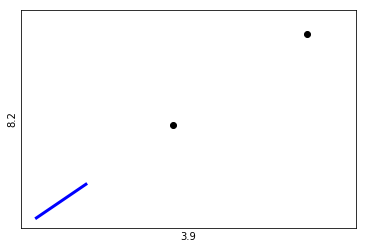

[0.147 0.16]
[0.21800000000000005 0.183]


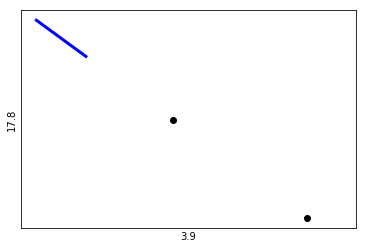

[0.147 0.16]
[0.21800000000000005 0.183]


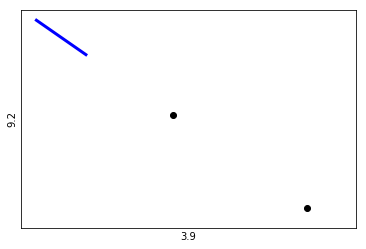

[0.147 0.16]
[0.21800000000000005 0.183]


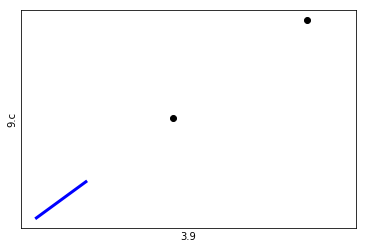

[0.147 0.16]
[0.21800000000000005 0.183]


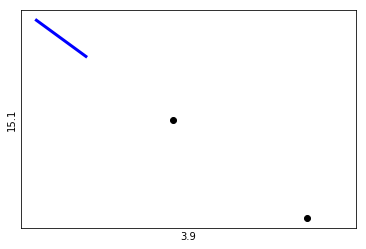

[0.147 0.16]
[0.21800000000000005 0.183]


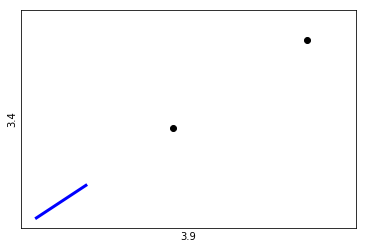

[0.16]
[]
[0.16]
[0.183]
[0.147 0.16]
[0.21800000000000005 0.183]


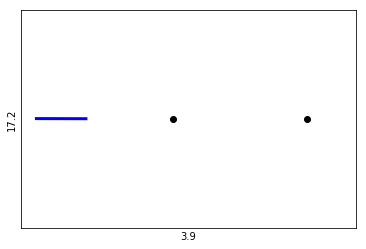

[0.147 0.16]
[0.21800000000000005 0.183]


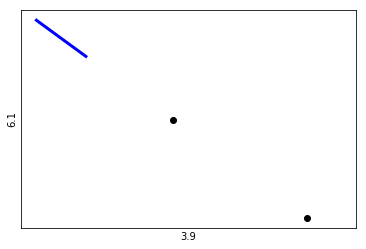

[0.147 0.16]
[0.21800000000000005 0.183]


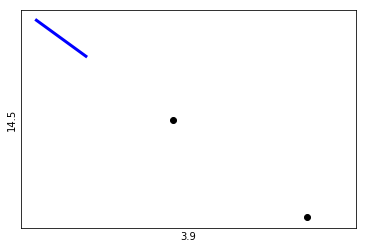

[9.0999999999999996 10.1]
[8.0]
[38.579999999999998 41.93]
[31.899999999999999 43.009999999999998]


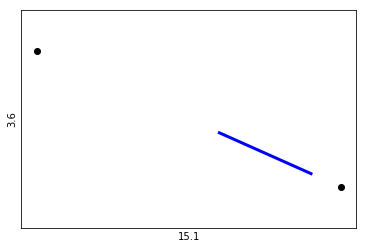

[43.189999999999998 38.579999999999998 43.229999999999997
 34.159999999999997 42.700000000000003 40.729999999999997
 33.060000000000002 42.18 41.93 39.420000000000002]
[37.450000000000003 41.700000000000003 31.899999999999999
 41.280000000000001 43.009999999999998 35.0]


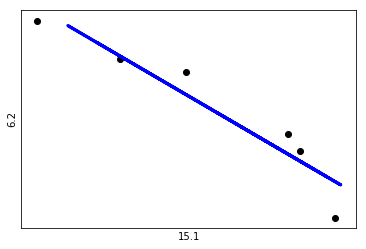

[35.0 43.189999999999998 38.579999999999998 34.159999999999997
 42.700000000000003 40.729999999999997 33.060000000000002 42.18 41.93
 39.420000000000002]
[37.450000000000003 41.700000000000003 31.899999999999999
 41.280000000000001 43.009999999999998]


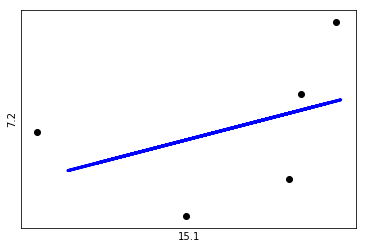

[43.229999999999997 42.700000000000003 42.18]
[43.009999999999998 43.189999999999998]


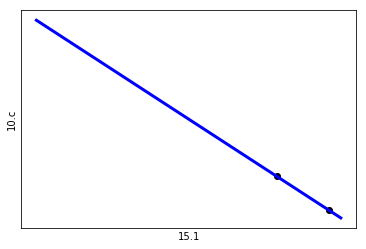

[43.229999999999997 41.93]
[31.899999999999999 38.579999999999998]


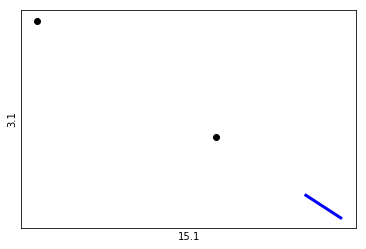

[43.189999999999998 38.579999999999998 43.229999999999997
 34.159999999999997 42.700000000000003 40.729999999999997
 33.060000000000002 42.18 41.93 43.229999999999997 39.420000000000002]
[37.450000000000003 41.700000000000003 31.899999999999999
 41.280000000000001 43.009999999999998 35.0]


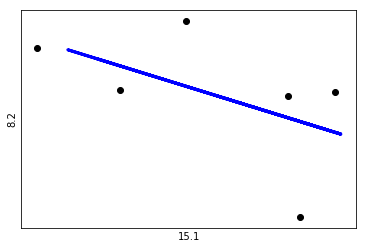

[43.189999999999998 38.579999999999998 43.229999999999997
 34.159999999999997 42.700000000000003 40.729999999999997
 33.060000000000002 42.18 41.93 39.420000000000002]
[37.450000000000003 41.700000000000003 31.899999999999999
 41.280000000000001 43.009999999999998 35.0]


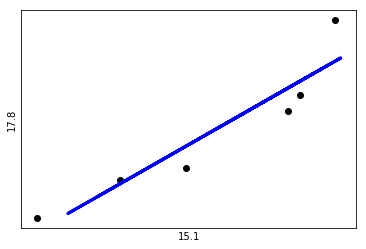

[43.189999999999998 38.579999999999998 43.229999999999997
 34.159999999999997 42.700000000000003 40.729999999999997
 33.060000000000002 42.18 41.93 43.229999999999997 39.420000000000002]
[37.450000000000003 41.700000000000003 31.899999999999999
 41.280000000000001 43.009999999999998 35.0]


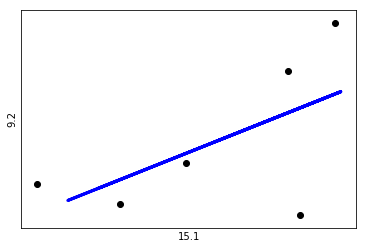

[43.189999999999998 38.579999999999998 43.229999999999997
 34.159999999999997 42.700000000000003 40.729999999999997
 33.060000000000002 42.18 41.93 39.420000000000002]
[37.450000000000003 41.700000000000003 31.899999999999999
 41.280000000000001 43.009999999999998 35.0]


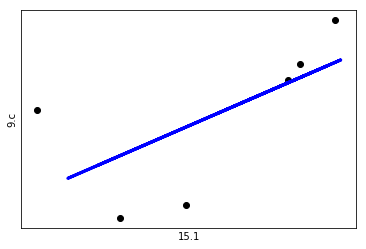

[43.229999999999997 41.93]
[31.899999999999999 38.579999999999998]


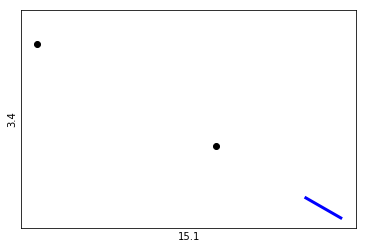

[43.189999999999998 42.700000000000003 40.729999999999997 42.18 41.93
 39.420000000000002]
[41.700000000000003 41.280000000000001 43.009999999999998]


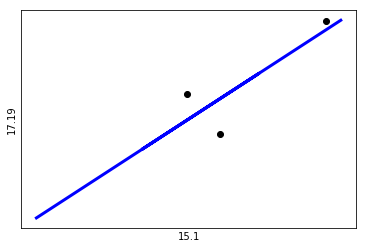

[35.0 43.189999999999998 38.579999999999998 42.700000000000003
 40.729999999999997 42.18 41.93 39.420000000000002]
[37.450000000000003 41.700000000000003 41.280000000000001
 43.009999999999998]


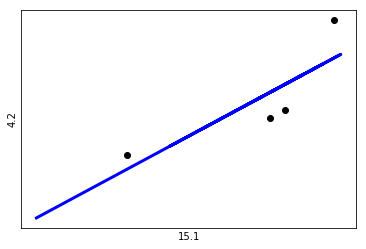

[43.189999999999998 38.579999999999998 43.229999999999997
 34.159999999999997 42.700000000000003 40.729999999999997
 33.060000000000002 42.18 41.93 43.229999999999997 39.420000000000002]
[37.450000000000003 41.700000000000003 31.899999999999999
 41.280000000000001 43.009999999999998 35.0]


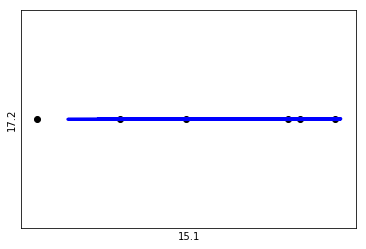

[43.189999999999998 38.579999999999998 43.229999999999997
 34.159999999999997 42.700000000000003 40.729999999999997
 33.060000000000002 42.18 41.93 39.420000000000002]
[37.450000000000003 41.700000000000003 31.899999999999999
 41.280000000000001 43.009999999999998 35.0]


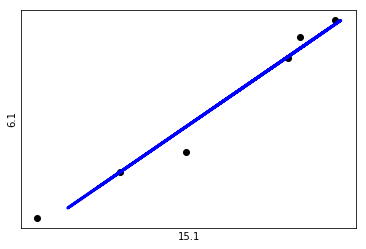

[43.229999999999997 41.93 43.229999999999997]
[31.899999999999999 38.579999999999998]


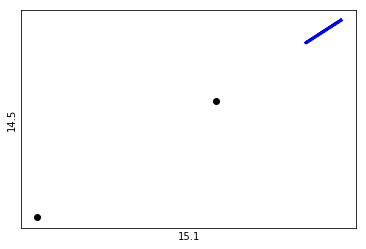

[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


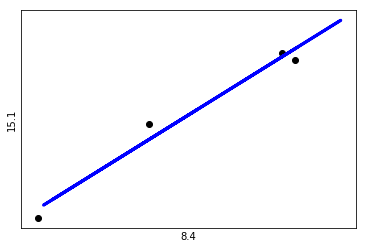

[1.161 1.123]
[1.222]
[1.073 1.123]
[1.222 1.161]


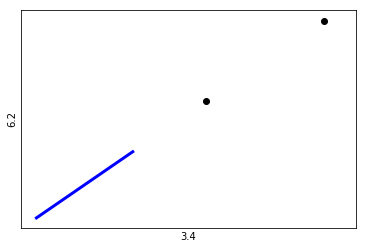

[1.161 1.123]
[1.222]
[1.073]
[]
[1.073 1.123]
[1.222 1.161]


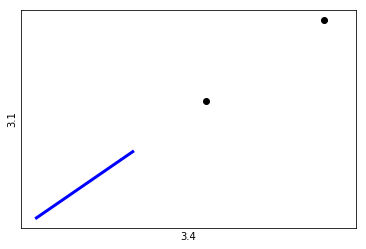

[1.073 1.123]
[1.222 1.161]


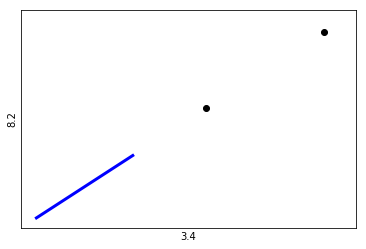

[1.073 1.123]
[1.222 1.161]


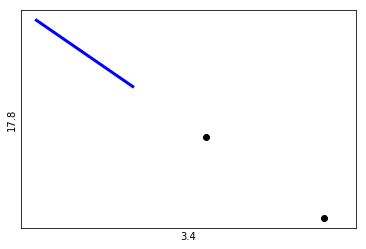

[1.073 1.123]
[1.222 1.161]


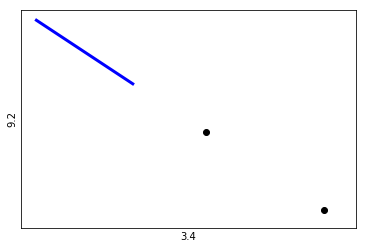

[1.073 1.123]
[1.222 1.161]


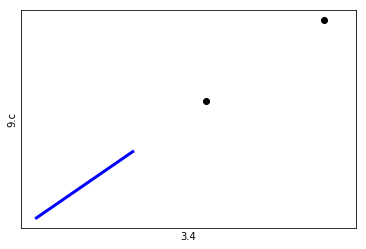

[1.123]
[]
[1.123]
[1.161]
[1.073 1.123]
[1.222 1.161]


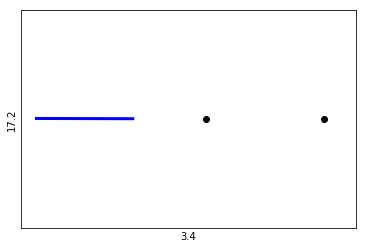

[1.073 1.123]
[1.222 1.161]


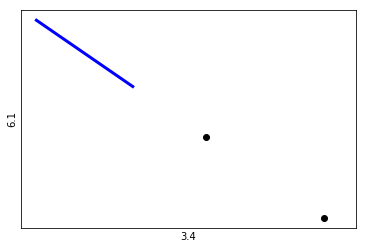

[1.073 1.123]
[1.222 1.161]


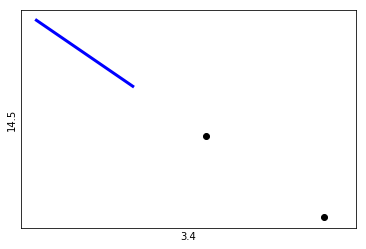

[9.0999999999999996 10.1]
[8.0]
[351996221.8]
[443106234.3]
[349844367.5 208600838.5 278254561.8 483067124.0 351996221.8 162618473.3]
[140684730.4 247953598.4 443106234.3]


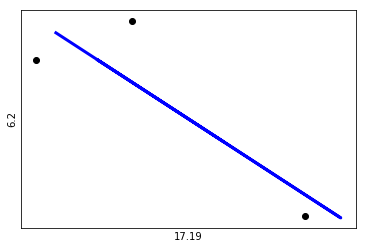

[349844367.5 208600838.5 278254561.8 483067124.0 351996221.8 162618473.3]
[140684730.4 247953598.4 443106234.3]


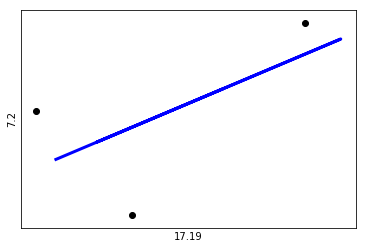

[208600838.5 483067124.0]
[443106234.3 349844367.5]


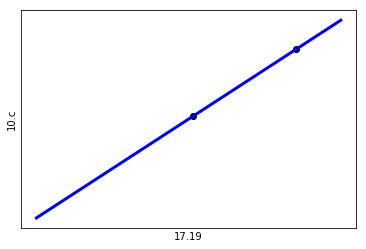

[351996221.8]
[]
[349844367.5 208600838.5 278254561.8 483067124.0 351996221.8 162618473.3]
[140684730.4 247953598.4 443106234.3]


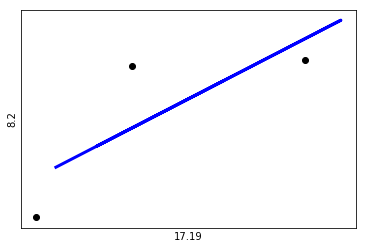

[349844367.5 208600838.5 278254561.8 483067124.0 351996221.8 162618473.3]
[140684730.4 247953598.4 443106234.3]


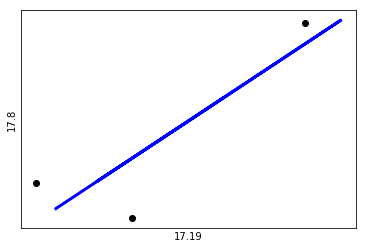

[349844367.5 208600838.5 278254561.8 483067124.0 351996221.8 162618473.3]
[140684730.4 247953598.4 443106234.3]


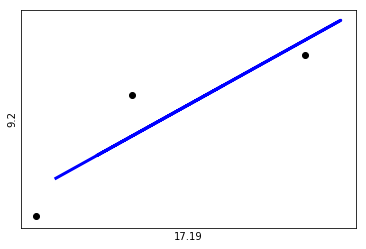

[349844367.5 208600838.5 278254561.8 483067124.0 351996221.8 162618473.3]
[140684730.4 247953598.4 443106234.3]


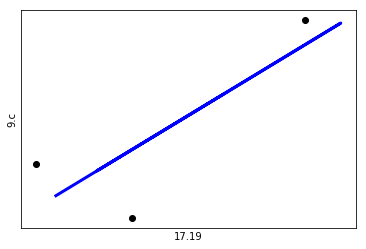

[349844367.5 208600838.5 278254561.8 483067124.0 351996221.8 162618473.3]
[140684730.4 247953598.4 443106234.3]


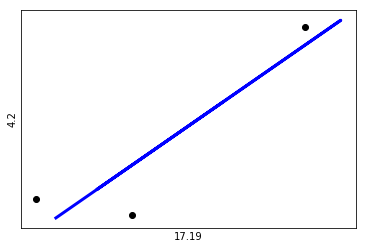

[349844367.5 208600838.5 278254561.8 483067124.0 351996221.8 162618473.3]
[140684730.4 247953598.4 443106234.3]


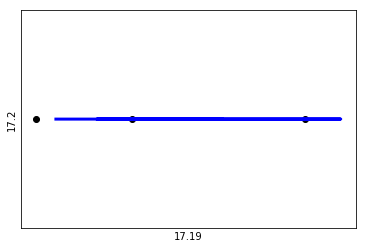

[349844367.5 208600838.5 278254561.8 483067124.0 351996221.8 162618473.3]
[140684730.4 247953598.4 443106234.3]


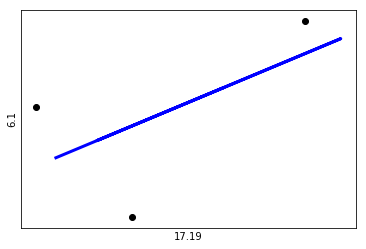

[351996221.8]
[]
[9.8000000000000007 10.1 9.4199999999999999]
[9.6899999999999995 9.7799999999999994]


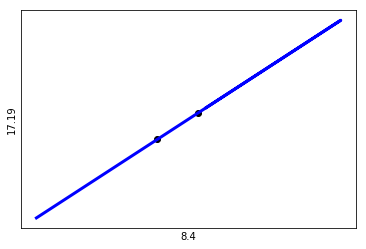

[57.420000000000002 60.439999999999998]
[65.200000000000003]
[56.689999999999998 66.590000000000003 57.420000000000002
 64.640000000000001 59.07 62.640000000000001 60.439999999999998
 58.659999999999997]
[56.509999999999998 59.409999999999997 58.890000000000001
 65.200000000000003]


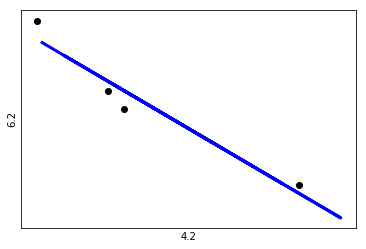

[56.689999999999998 66.590000000000003 57.420000000000002
 64.640000000000001 59.07 62.640000000000001 60.439999999999998
 58.659999999999997]
[56.509999999999998 59.409999999999997 58.890000000000001
 65.200000000000003]


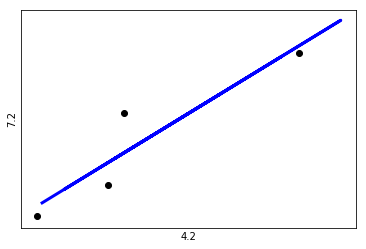

[64.640000000000001 62.640000000000001]
[65.200000000000003 66.590000000000003]


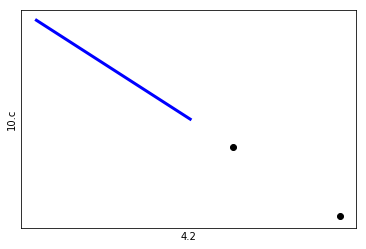

[60.439999999999998]
[57.420000000000002]
[56.689999999999998 66.590000000000003 57.420000000000002
 64.640000000000001 59.07 62.640000000000001 60.439999999999998
 58.659999999999997]
[56.509999999999998 59.409999999999997 58.890000000000001
 65.200000000000003]


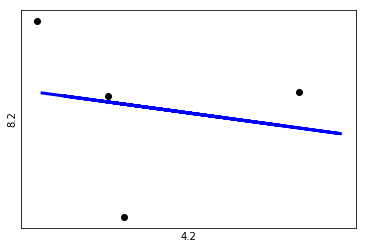

[56.689999999999998 66.590000000000003 57.420000000000002
 64.640000000000001 59.07 62.640000000000001 60.439999999999998
 58.659999999999997]
[56.509999999999998 59.409999999999997 58.890000000000001
 65.200000000000003]


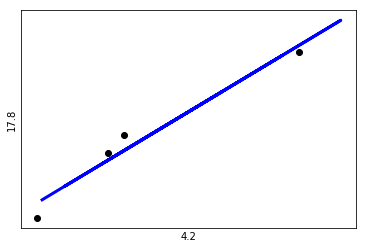

[56.689999999999998 66.590000000000003 57.420000000000002
 64.640000000000001 59.07 62.640000000000001 60.439999999999998
 58.659999999999997]
[56.509999999999998 59.409999999999997 58.890000000000001
 65.200000000000003]


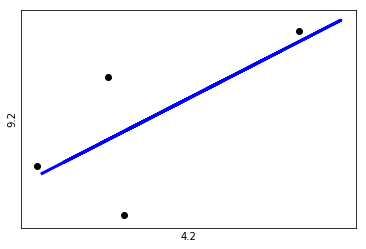

[56.689999999999998 66.590000000000003 57.420000000000002
 64.640000000000001 59.07 62.640000000000001 60.439999999999998
 58.659999999999997]
[56.509999999999998 59.409999999999997 58.890000000000001
 65.200000000000003]


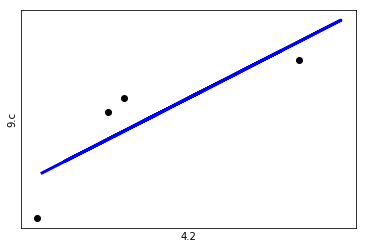

[56.689999999999998 66.590000000000003 57.420000000000002
 64.640000000000001 59.07 62.640000000000001 60.439999999999998
 58.659999999999997]
[56.509999999999998 59.409999999999997 58.890000000000001
 65.200000000000003]


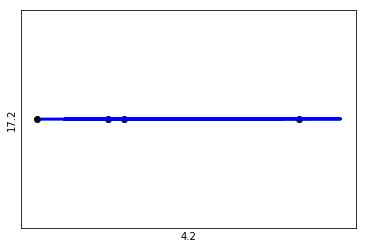

[56.689999999999998 66.590000000000003 57.420000000000002
 64.640000000000001 59.07 62.640000000000001 60.439999999999998
 58.659999999999997]
[56.509999999999998 59.409999999999997 58.890000000000001
 65.200000000000003]


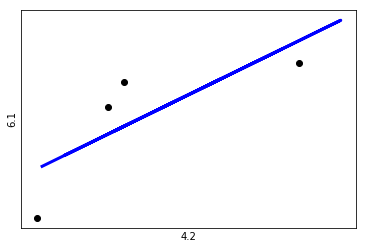

[60.439999999999998]
[57.420000000000002]
[8.4199999999999999 9.0999999999999996 9.8000000000000007 10.1
 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 9.7799999999999994]


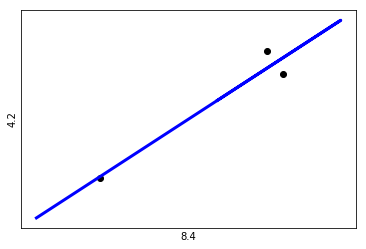

[0.00011529866000000001 0.00012063026]
[7.085187e-05 0.00012183828000000001]


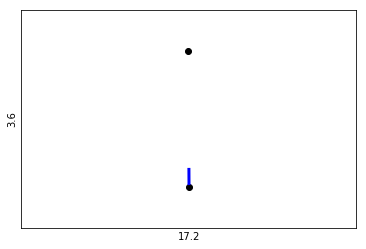

[0.00012394578 0.00011529866000000001 0.00013155531 7.840898e-05
 0.0001153076 0.00010032951999999999 7.301923e-05 0.00011967333999999999
 0.00012063026 0.00010909383]
[8.757594000000001e-05 0.00011428076000000001 7.085187e-05 0.00011224165
 0.00012183828000000001 8.239146000000001e-05]


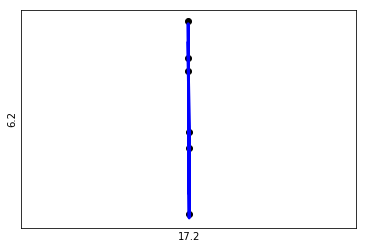

[8.239146000000001e-05 0.00012394578 0.00011529866000000001 7.840898e-05
 0.0001153076 0.00010032951999999999 7.301923e-05 0.00011967333999999999
 0.00012063026 0.00010909383]
[8.757594000000001e-05 0.00011428076000000001 7.085187e-05 0.00011224165
 0.00012183828000000001]


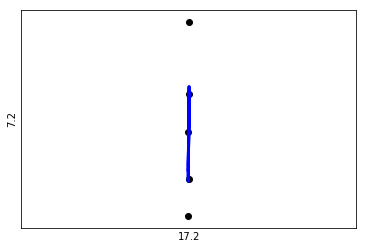

[0.00013155531 0.0001153076 0.00011967333999999999]
[0.00012183828000000001 0.00012394578]


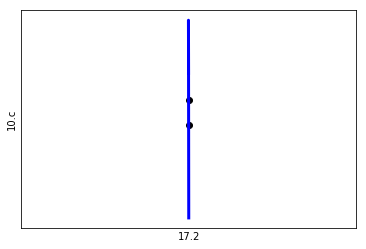

[0.00013155531 0.00012063026]
[7.085187e-05 0.00011529866000000001]


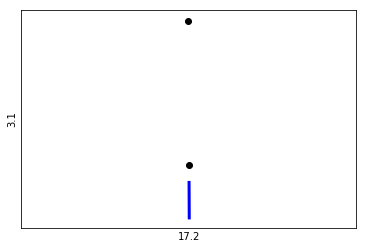

[0.00012394578 0.00011529866000000001 0.00013155531 7.840898e-05
 0.0001153076 0.00010032951999999999 7.301923e-05 0.00011967333999999999
 0.00012063026 0.00014332870000000002 0.00010909383]
[8.757594000000001e-05 0.00011428076000000001 7.085187e-05 0.00011224165
 0.00012183828000000001 8.239146000000001e-05]


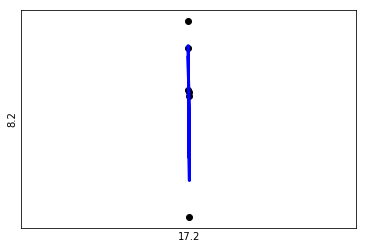

[0.00012394578 0.00011529866000000001 0.00013155531 7.840898e-05
 0.0001153076 0.00010032951999999999 7.301923e-05 0.00011967333999999999
 0.00012063026 0.00010909383]
[8.757594000000001e-05 0.00011428076000000001 7.085187e-05 0.00011224165
 0.00012183828000000001 8.239146000000001e-05]


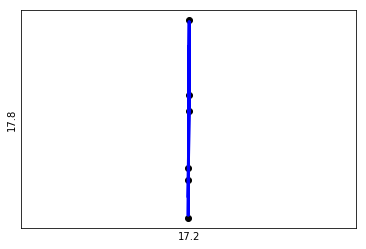

[0.00012394578 0.00011529866000000001 0.00013155531 7.840898e-05
 0.0001153076 0.00010032951999999999 7.301923e-05 0.00011967333999999999
 0.00012063026 0.00014332870000000002 0.00010909383]
[8.757594000000001e-05 0.00011428076000000001 7.085187e-05 0.00011224165
 0.00012183828000000001 8.239146000000001e-05]


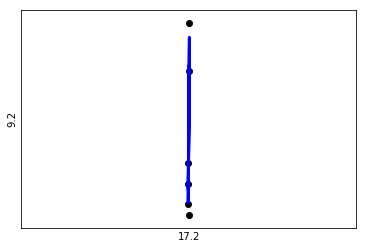

[0.00012394578 0.00011529866000000001 0.00013155531 7.840898e-05
 0.0001153076 0.00010032951999999999 7.301923e-05 0.00011967333999999999
 0.00012063026 0.00010909383]
[8.757594000000001e-05 0.00011428076000000001 7.085187e-05 0.00011224165
 0.00012183828000000001 8.239146000000001e-05]


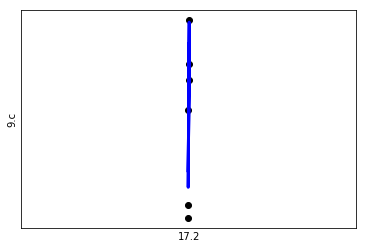

[0.00012394578 0.00011529866000000001 0.00013155531 7.840898e-05
 0.0001153076 0.00010032951999999999 7.301923e-05 0.00011967333999999999
 0.00012063026 0.00010909383]
[8.757594000000001e-05 0.00011428076000000001 7.085187e-05 0.00011224165
 0.00012183828000000001 8.239146000000001e-05]


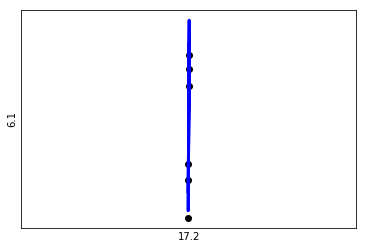

[0.00013155531 0.00012063026 0.00014332870000000002]
[7.085187e-05 0.00011529866000000001]


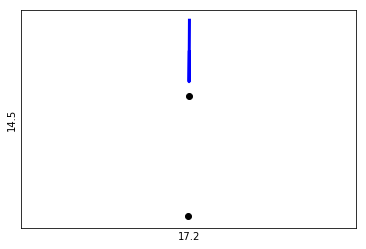

[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


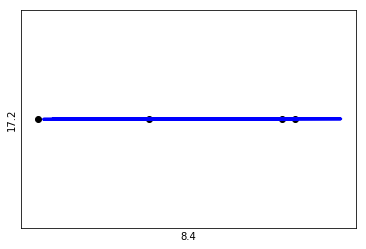

[47.969999999999999 55.549999999999997]
[40.950000000000003 55.219999999999999]


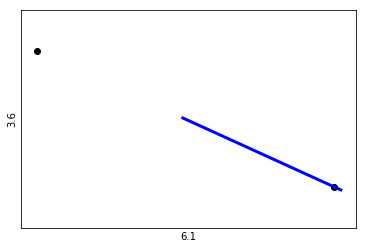

[55.030000000000001 47.969999999999999 54.810000000000002
 42.840000000000003 55.770000000000003 50.979999999999997
 41.310000000000002 55.909999999999997 55.549999999999997
 49.460000000000001]
[45.689999999999998 54.020000000000003 40.950000000000003
 52.490000000000002 55.219999999999999 44.229999999999997]


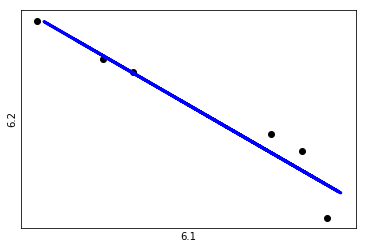

[44.229999999999997 55.030000000000001 47.969999999999999
 42.840000000000003 55.770000000000003 50.979999999999997
 41.310000000000002 55.909999999999997 55.549999999999997
 49.460000000000001]
[45.689999999999998 54.020000000000003 40.950000000000003
 52.490000000000002 55.219999999999999]


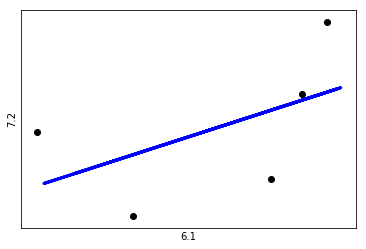

[54.810000000000002 55.770000000000003 55.909999999999997]
[55.219999999999999 55.030000000000001]


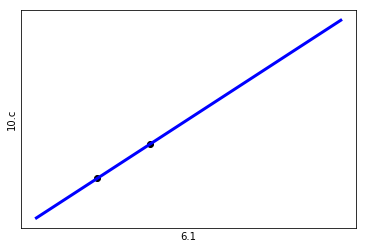

[54.810000000000002 55.549999999999997]
[40.950000000000003 47.969999999999999]


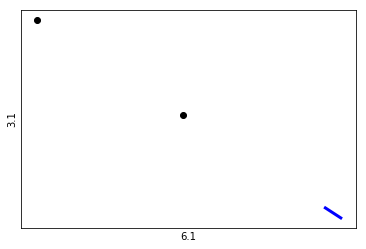

[55.030000000000001 47.969999999999999 54.810000000000002
 42.840000000000003 55.770000000000003 50.979999999999997
 41.310000000000002 55.909999999999997 55.549999999999997
 49.460000000000001]
[45.689999999999998 54.020000000000003 40.950000000000003
 52.490000000000002 55.219999999999999 44.229999999999997]


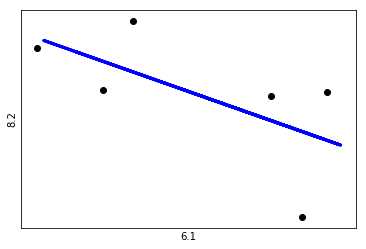

[55.030000000000001 47.969999999999999 54.810000000000002
 42.840000000000003 55.770000000000003 50.979999999999997
 41.310000000000002 55.909999999999997 55.549999999999997
 49.460000000000001]
[45.689999999999998 54.020000000000003 40.950000000000003
 52.490000000000002 55.219999999999999 44.229999999999997]


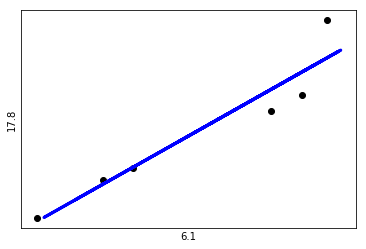

[55.030000000000001 47.969999999999999 54.810000000000002
 42.840000000000003 55.770000000000003 50.979999999999997
 41.310000000000002 55.909999999999997 55.549999999999997
 49.460000000000001]
[45.689999999999998 54.020000000000003 40.950000000000003
 52.490000000000002 55.219999999999999 44.229999999999997]


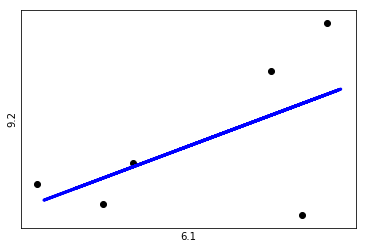

[55.030000000000001 47.969999999999999 54.810000000000002
 42.840000000000003 55.770000000000003 50.979999999999997
 41.310000000000002 55.909999999999997 55.549999999999997
 49.460000000000001]
[45.689999999999998 54.020000000000003 40.950000000000003
 52.490000000000002 55.219999999999999 44.229999999999997]


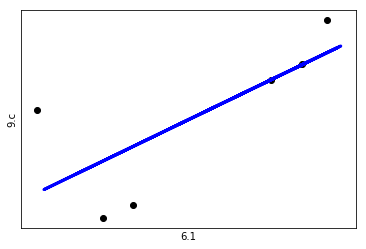

[54.810000000000002 55.549999999999997]
[40.950000000000003 47.969999999999999]


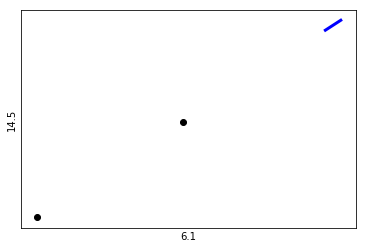

[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


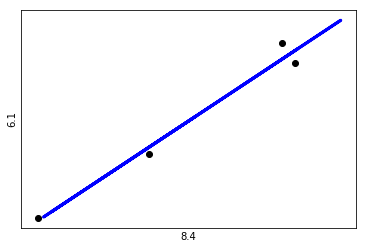

[2.89 7.44]
[1.72]
[11.92 7.44]
[1.72 2.89]


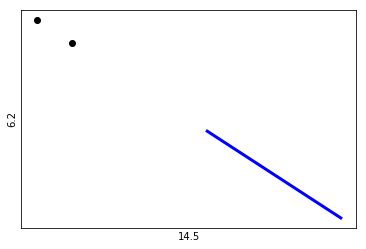

[2.89 7.44]
[1.72]
[11.92]
[]
[11.92 7.44]
[1.72 2.89]


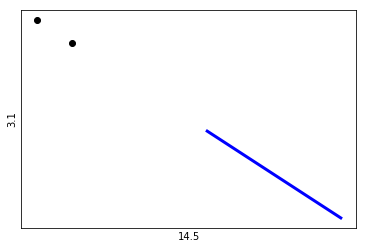

[11.92 7.44 12.74]
[1.72 2.89]


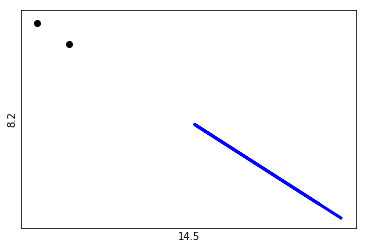

[11.92 7.44]
[1.72 2.89]


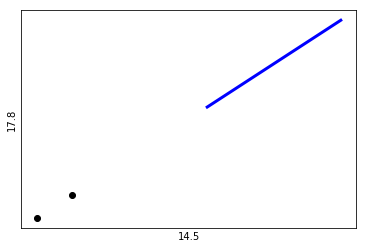

[11.92 7.44 12.74]
[1.72 2.89]


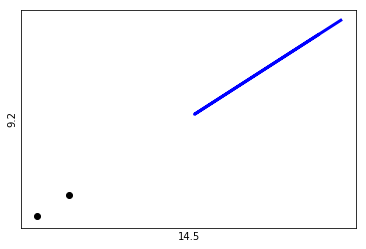

[11.92 7.44]
[1.72 2.89]


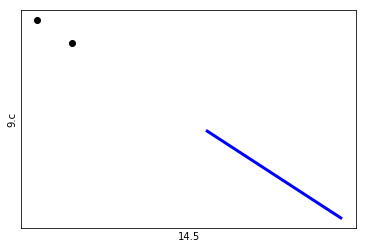

[9.0999999999999996 10.1]
[8.0]
[9.0999999999999996 10.1]
[8.0]
[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


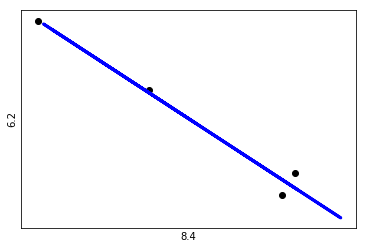

[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


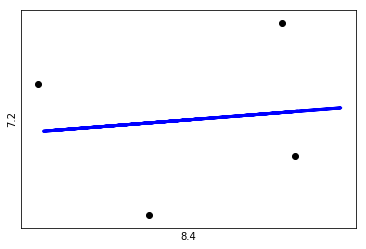

[]
[]
[9.0999999999999996 10.1]
[8.0]
[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


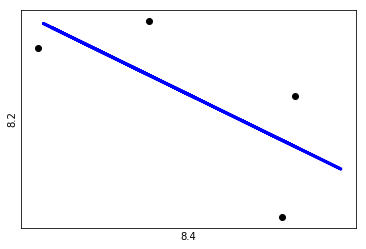

[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


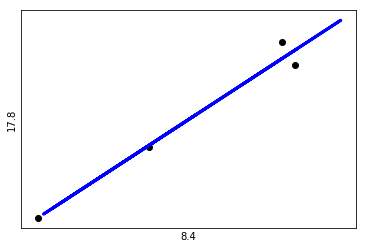

[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


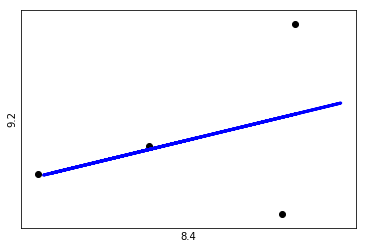

[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


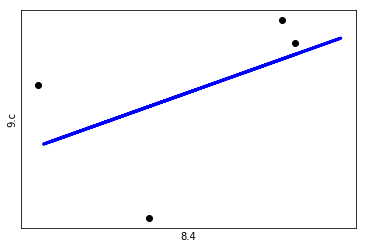

[16.899999999999999 15.5]
[17.199999999999999 14.699999999999999]


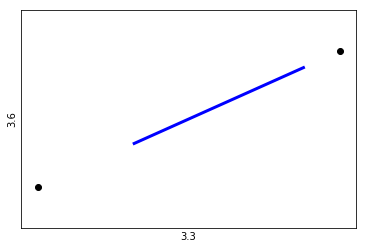

[14.4 16.899999999999999 14.199999999999999 17.199999999999999 15.0
 16.399999999999999 17.199999999999999 15.300000000000001 15.5
 16.600000000000001]
[17.0 15.9 17.199999999999999 16.100000000000001 14.699999999999999
 17.199999999999999]


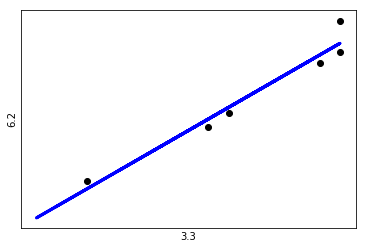

[17.199999999999999 14.4 16.899999999999999 17.199999999999999 15.0
 16.399999999999999 17.199999999999999 15.300000000000001 15.5
 16.600000000000001]
[17.0 15.9 17.199999999999999 16.100000000000001 14.699999999999999]


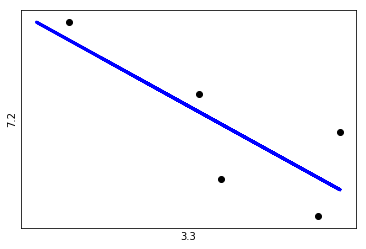

[14.199999999999999 15.0 15.300000000000001]
[14.699999999999999 14.4]


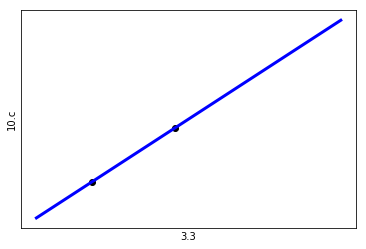

[14.199999999999999 15.5]
[17.199999999999999 16.899999999999999]


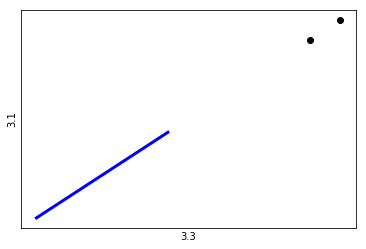

[14.4 16.899999999999999 14.199999999999999 17.199999999999999 15.0
 16.399999999999999 17.199999999999999 15.300000000000001 15.5
 16.600000000000001]
[17.0 15.9 17.199999999999999 16.100000000000001 14.699999999999999
 17.199999999999999]


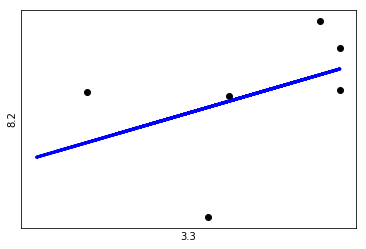

[14.4 16.899999999999999 14.199999999999999 17.199999999999999 15.0
 16.399999999999999 17.199999999999999 15.300000000000001 15.5
 16.600000000000001]
[17.0 15.9 17.199999999999999 16.100000000000001 14.699999999999999
 17.199999999999999]


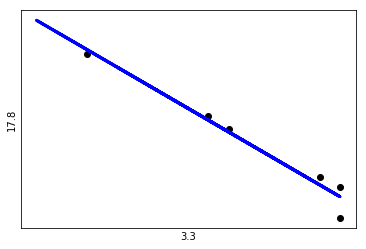

[14.4 16.899999999999999 14.199999999999999 17.199999999999999 15.0
 16.399999999999999 17.199999999999999 15.300000000000001 15.5
 16.600000000000001]
[17.0 15.9 17.199999999999999 16.100000000000001 14.699999999999999
 17.199999999999999]


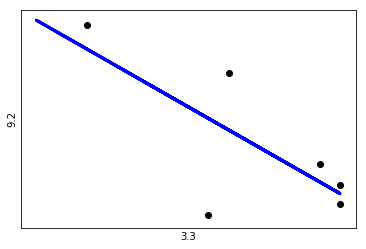

[14.4 16.899999999999999 14.199999999999999 17.199999999999999 15.0
 16.399999999999999 17.199999999999999 15.300000000000001 15.5
 16.600000000000001]
[17.0 15.9 17.199999999999999 16.100000000000001 14.699999999999999
 17.199999999999999]


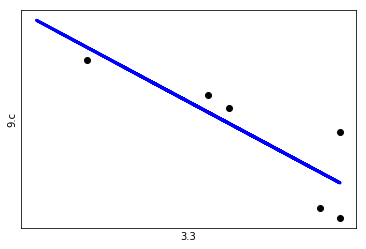

[14.4 16.899999999999999 14.199999999999999 17.199999999999999 15.0
 16.399999999999999 17.199999999999999 15.300000000000001 15.5
 16.600000000000001]
[17.0 15.9 17.199999999999999 16.100000000000001 14.699999999999999
 17.199999999999999]


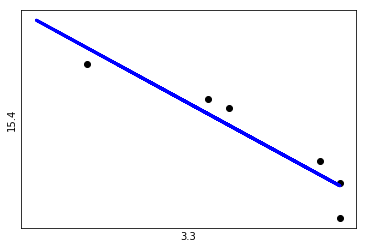

[14.199999999999999 15.5]
[17.199999999999999 16.899999999999999]


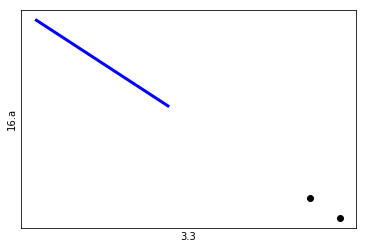

[16.100000000000001 14.699999999999999 15.300000000000001
 16.600000000000001]
[17.0 15.9 17.199999999999999]


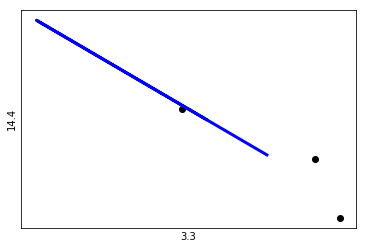

[16.899999999999999 15.5]
[17.199999999999999 14.4]


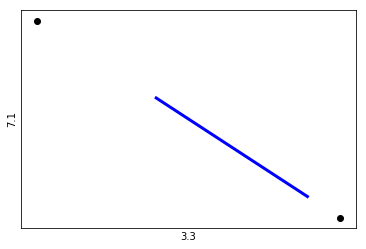

[14.4 16.899999999999999 14.199999999999999 17.199999999999999 15.0
 16.399999999999999 17.199999999999999 15.300000000000001 15.5
 16.600000000000001]
[17.0 15.9 17.199999999999999 16.100000000000001 14.699999999999999
 17.199999999999999]


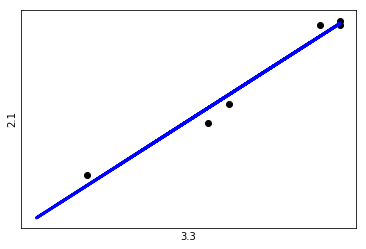

[14.4 16.899999999999999 14.199999999999999 17.199999999999999 15.0
 16.399999999999999 17.199999999999999 15.300000000000001 15.5
 16.600000000000001]
[17.0 15.9 17.199999999999999 16.100000000000001 14.699999999999999
 17.199999999999999]


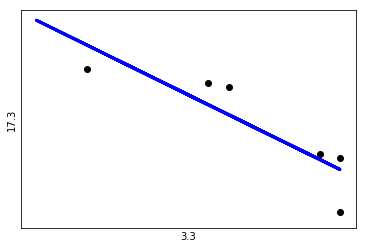

[15.5]
[14.4]
[14.199999999999999 15.5]
[17.199999999999999 16.899999999999999]


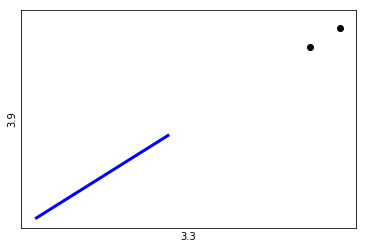

[14.4 16.899999999999999 14.199999999999999 17.199999999999999 15.0
 16.399999999999999 17.199999999999999 15.300000000000001 15.5
 16.600000000000001]
[17.0 15.9 17.199999999999999 16.100000000000001 14.699999999999999
 17.199999999999999]


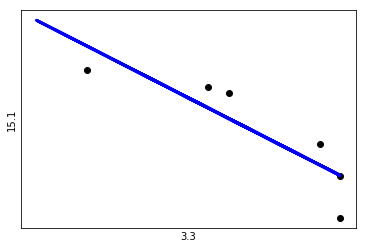

[14.199999999999999 15.5]
[17.199999999999999 16.899999999999999]


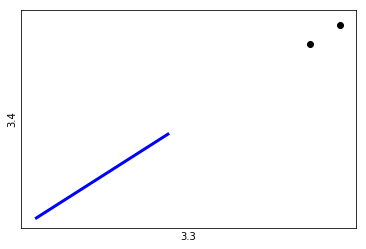

[14.4 15.0 16.399999999999999 15.300000000000001 15.5 16.600000000000001]
[15.9 16.100000000000001 14.699999999999999]


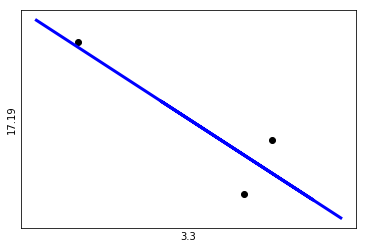

[17.199999999999999 14.4 16.899999999999999 15.0 16.399999999999999
 15.300000000000001 15.5 16.600000000000001]
[17.0 15.9 16.100000000000001 14.699999999999999]


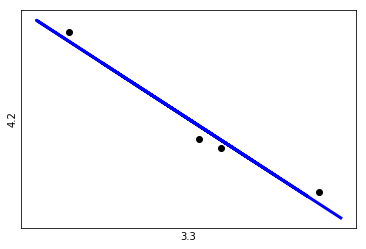

[14.4 16.899999999999999 14.199999999999999 17.199999999999999 15.0
 16.399999999999999 17.199999999999999 15.300000000000001 15.5
 16.600000000000001]
[17.0 15.9 17.199999999999999 16.100000000000001 14.699999999999999
 17.199999999999999]


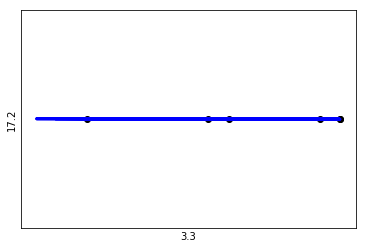

[14.4 16.899999999999999 14.199999999999999 17.199999999999999 15.0
 16.399999999999999 17.199999999999999 15.300000000000001 15.5
 16.600000000000001]
[17.0 15.9 17.199999999999999 16.100000000000001 14.699999999999999
 17.199999999999999]


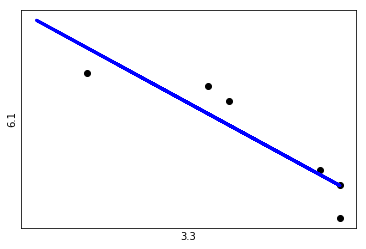

[14.199999999999999 15.5]
[17.199999999999999 16.899999999999999]


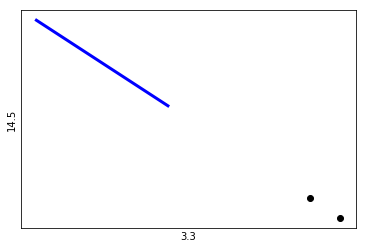

[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


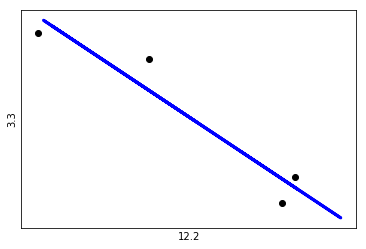

[]
[]
[]
[]
[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


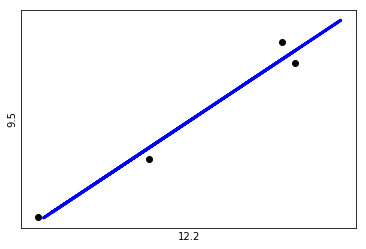

[9.0999999999999996]
[]
[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


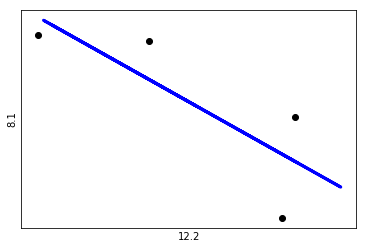

[9.0999999999999996 10.1]
[8.0]
[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


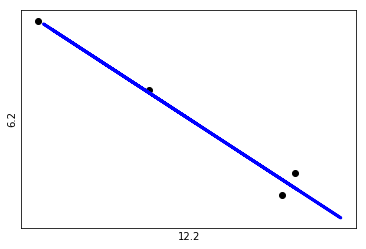

[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


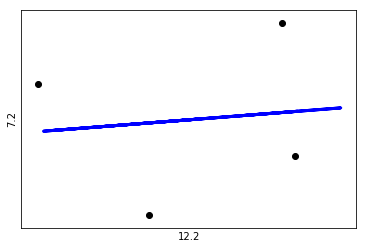

[]
[]
[9.0999999999999996 10.1]
[8.0]
[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


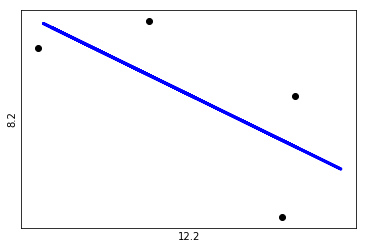

[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


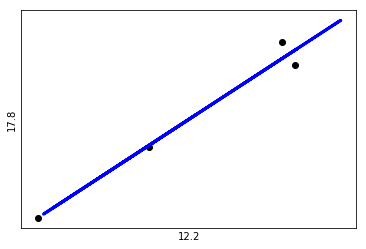

[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


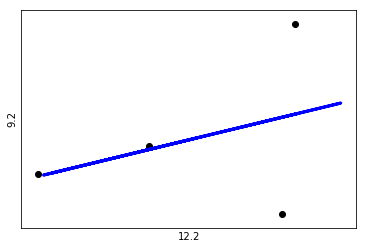

[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


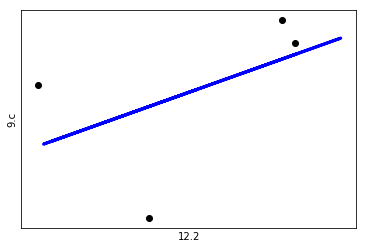

[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


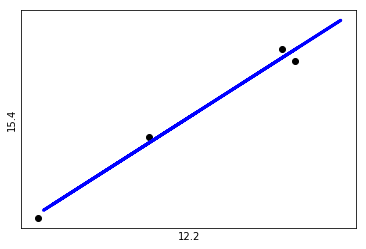

[9.0999999999999996 10.1]
[8.0]
[8.0 9.7799999999999994 9.4199999999999999]
[8.7699999999999996 9.6899999999999995]


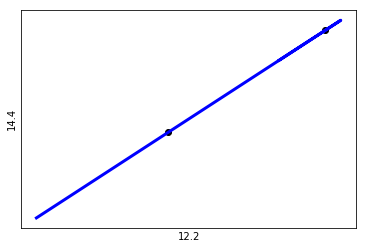

[9.0999999999999996 10.1]
[8.0]
[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


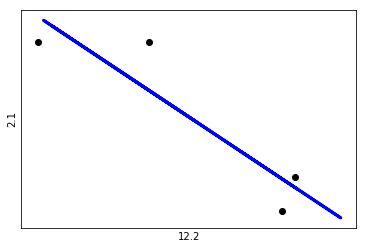

[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


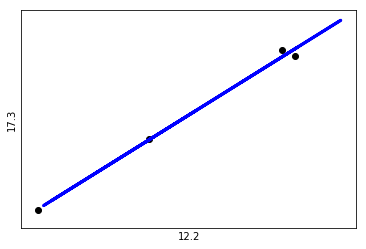

[10.1]
[]
[9.0999999999999996 10.1]
[8.0]
[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


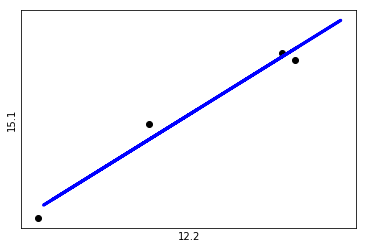

[9.0999999999999996 10.1]
[8.0]
[9.8000000000000007 10.1 9.4199999999999999]
[9.6899999999999995 9.7799999999999994]


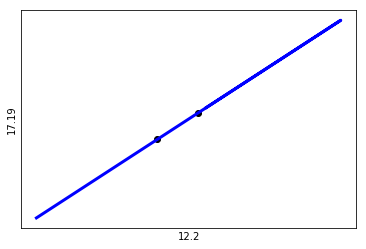

[8.4199999999999999 9.0999999999999996 9.8000000000000007 10.1
 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 9.7799999999999994]


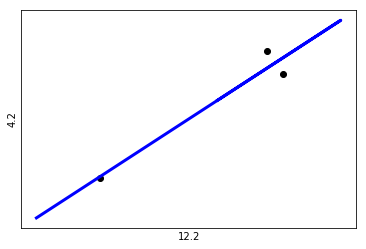

[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


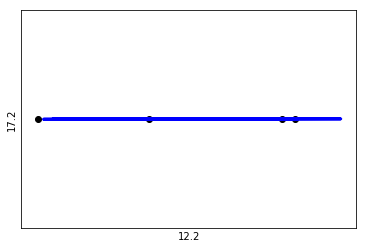

[8.4199999999999999 9.0999999999999996 8.0999999999999996
 9.8000000000000007 8.0399999999999991 10.1 9.4199999999999999]
[8.7699999999999996 9.6899999999999995 8.0 9.7799999999999994]


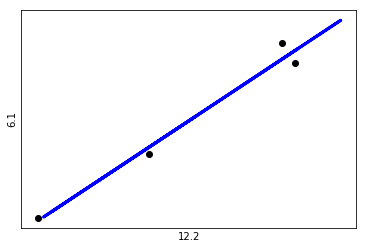

[9.0999999999999996 10.1]
[8.0]
[10.699999999999999]
[]
[10.699999999999999]
[]
[10.699999999999999]
[]
[10.699999999999999]
[]
[]
[]
[10.699999999999999]
[]
[10.699999999999999]
[]
[10.699999999999999]
[]
[10.699999999999999]
[]
[10.699999999999999]
[]
[]
[]
[10.699999999999999]
[]
[]
[]
[28.0]
[10.699999999999999]
[10.699999999999999]
[]
[]
[]
[]
[]
[10.699999999999999]
[]
[]
[]
[10.699999999999999]
[]
[10.699999999999999]
[]
[10.699999999999999]
[]
[10.699999999999999]
[]
[]
[]
[10.699999999999999]
[]
[]
[]
[10.699999999999999]
[]
[]
[]
[10.699999999999999]
[]
[]
[]
[22.34]
[]
[22.34]
[]
[22.34]
[]
[]
[]
[22.34]
[]
[22.34]
[]
[22.34]
[]
[22.34]
[]
[22.34]
[21.620000000000001]
[]
[]
[]
[]
[22.34]
[]
[22.34]
[]
[22.34]
[]
[22.34]
[]
[]
[]
[22.34]
[21.620000000000001]
[]
[]
[22.34]
[]
[22.34]
[]
[22.34]
[]
[22.34]
[]
[]
[]
[22.34]
[]
[22.34]
[]
[]
[]
[22.34]
[]
[90.737000000000009 101.895]
[80.637 108.754]


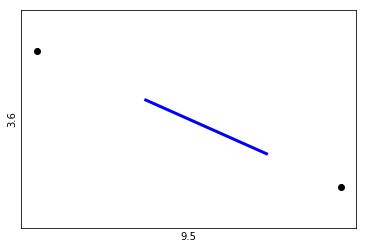

[86.359999999999999 109.83799999999999 90.737000000000009
 83.457999999999998 106.63600000000001 95.844999999999999
 82.430999999999997 104.66799999999999 101.895 92.935000000000002]
[87.311000000000007 100.75200000000001 80.637 98.35799999999999 108.754]


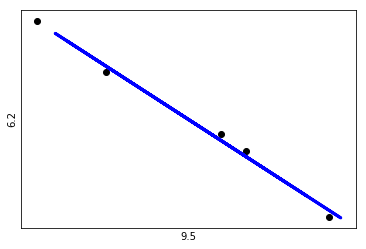

[86.359999999999999 109.83799999999999 90.737000000000009
 83.457999999999998 106.63600000000001 95.844999999999999
 82.430999999999997 104.66799999999999 101.895 92.935000000000002]
[87.311000000000007 100.75200000000001 80.637 98.35799999999999 108.754]


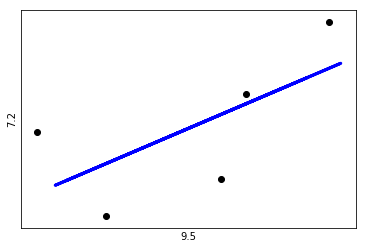

[106.63600000000001 104.66799999999999]
[108.754 109.83799999999999]


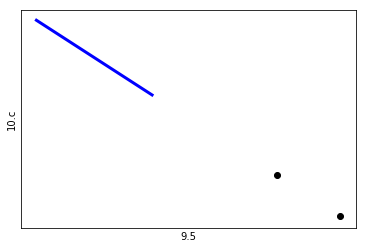

[90.737000000000009 101.895]
[80.637]
[86.359999999999999 109.83799999999999 90.737000000000009
 83.457999999999998 106.63600000000001 95.844999999999999
 82.430999999999997 104.66799999999999 101.895 92.935000000000002]
[87.311000000000007 100.75200000000001 80.637 98.35799999999999 108.754]


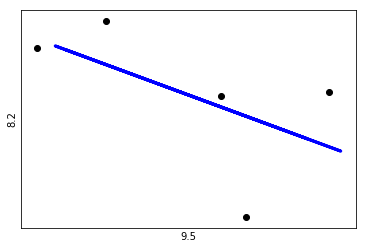

[86.359999999999999 109.83799999999999 90.737000000000009
 83.457999999999998 106.63600000000001 95.844999999999999
 82.430999999999997 104.66799999999999 101.895 92.935000000000002]
[87.311000000000007 100.75200000000001 80.637 98.35799999999999 108.754]


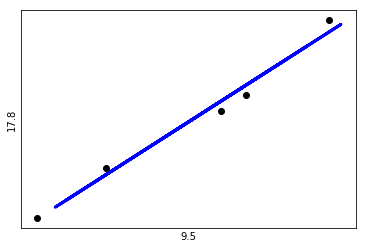

[86.359999999999999 109.83799999999999 90.737000000000009
 83.457999999999998 106.63600000000001 95.844999999999999
 82.430999999999997 104.66799999999999 101.895 92.935000000000002]
[87.311000000000007 100.75200000000001 80.637 98.35799999999999 108.754]


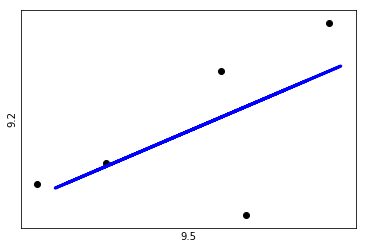

[86.359999999999999 109.83799999999999 90.737000000000009
 83.457999999999998 106.63600000000001 95.844999999999999
 82.430999999999997 104.66799999999999 101.895 92.935000000000002]
[87.311000000000007 100.75200000000001 80.637 98.35799999999999 108.754]


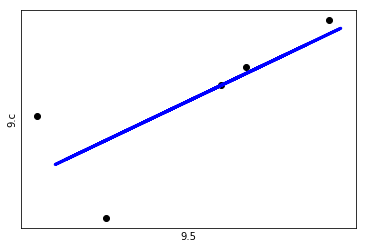

[86.359999999999999 109.83799999999999 90.737000000000009
 83.457999999999998 106.63600000000001 95.844999999999999
 82.430999999999997 104.66799999999999 101.895 92.935000000000002]
[87.311000000000007 100.75200000000001 80.637 98.35799999999999 108.754]


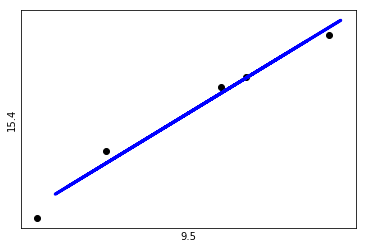

[90.737000000000009 101.895]
[80.637]
[98.35799999999999 108.754 104.66799999999999 92.935000000000002]
[87.311000000000007 100.75200000000001 80.637]


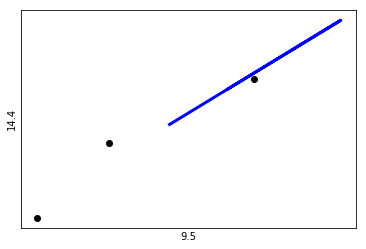

[90.737000000000009 101.895]
[80.637 109.83799999999999]


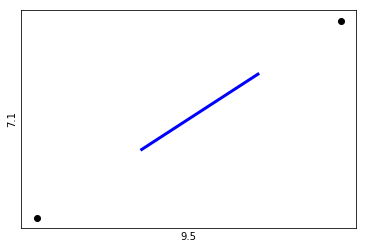

[86.359999999999999 109.83799999999999 90.737000000000009
 83.457999999999998 106.63600000000001 95.844999999999999
 82.430999999999997 104.66799999999999 101.895 92.935000000000002]
[87.311000000000007 100.75200000000001 80.637 98.35799999999999 108.754]


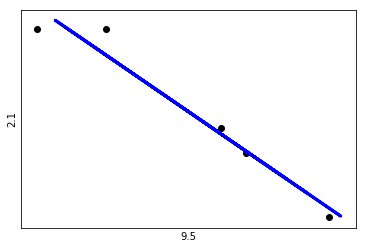

[86.359999999999999 109.83799999999999 90.737000000000009
 83.457999999999998 106.63600000000001 95.844999999999999
 82.430999999999997 104.66799999999999 101.895 92.935000000000002]
[87.311000000000007 100.75200000000001 80.637 98.35799999999999 108.754]


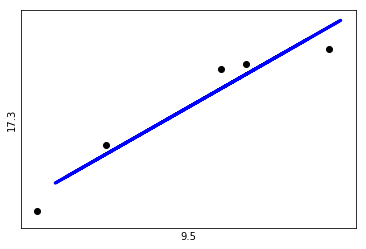

[101.895]
[109.83799999999999]
[90.737000000000009 101.895]
[80.637]
[86.359999999999999 109.83799999999999 90.737000000000009
 83.457999999999998 106.63600000000001 95.844999999999999
 82.430999999999997 104.66799999999999 101.895 92.935000000000002]
[87.311000000000007 100.75200000000001 80.637 98.35799999999999 108.754]


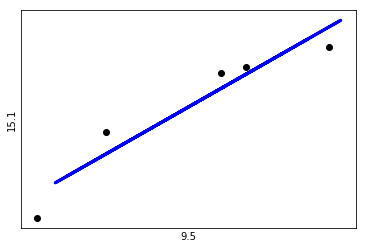

[90.737000000000009 101.895]
[80.637]
[109.83799999999999 106.63600000000001 95.844999999999999
 104.66799999999999 101.895 92.935000000000002]
[100.75200000000001 98.35799999999999 108.754]


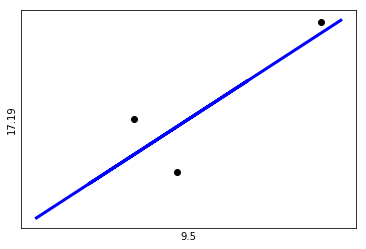

[86.359999999999999 109.83799999999999 90.737000000000009
 106.63600000000001 95.844999999999999 104.66799999999999 101.895
 92.935000000000002]
[87.311000000000007 100.75200000000001 98.35799999999999 108.754]


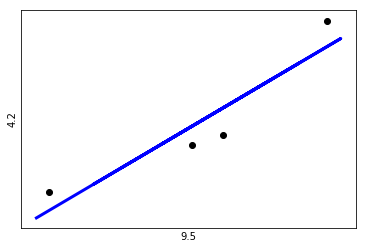

[86.359999999999999 109.83799999999999 90.737000000000009
 83.457999999999998 106.63600000000001 95.844999999999999
 82.430999999999997 104.66799999999999 101.895 92.935000000000002]
[87.311000000000007 100.75200000000001 80.637 98.35799999999999 108.754]


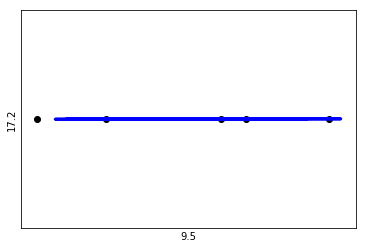

[86.359999999999999 109.83799999999999 90.737000000000009
 83.457999999999998 106.63600000000001 95.844999999999999
 82.430999999999997 104.66799999999999 101.895 92.935000000000002]
[87.311000000000007 100.75200000000001 80.637 98.35799999999999 108.754]


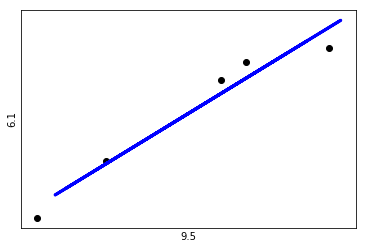

[90.737000000000009 101.895]
[80.637]
[86.359999999999999 109.83799999999999 90.737000000000009
 83.457999999999998 106.63600000000001 95.844999999999999
 82.430999999999997 104.66799999999999 101.895 92.935000000000002]
[87.311000000000007 100.75200000000001 80.637 98.35799999999999 108.754]


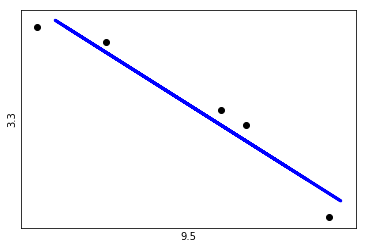

[90.737000000000009]
[]
[86.359999999999999 109.83799999999999 90.737000000000009
 83.457999999999998 106.63600000000001 95.844999999999999
 82.430999999999997 104.66799999999999 101.895 92.935000000000002]
[87.311000000000007 100.75200000000001 80.637 98.35799999999999 108.754]


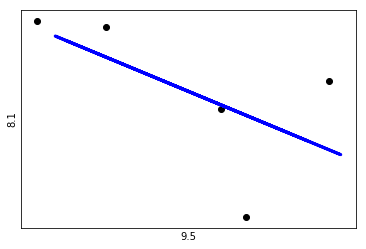

[32.0]
[]
[31.0]
[32.0]
[32.0]
[]
[31.0]
[]
[31.0]
[32.0]
[31.0]
[32.0]
[31.0]
[32.0]
[31.0]
[32.0]
[31.0]
[32.0]
[31.0]
[32.0]
[31.0]
[32.0]
[]
[]
[32.0]
[]
[31.0]
[32.0]
[31.0]
[32.0]
[]
[]
[31.0]
[32.0]
[31.0]
[32.0]
[31.0]
[32.0]
[]
[]
[32.0]
[]
[31.0]
[32.0]
[31.0]
[32.0]
[31.0]
[32.0]
[31.0]
[32.0]
[31.0]
[32.0]
[2.35 2.82]
[3.01 1.08]


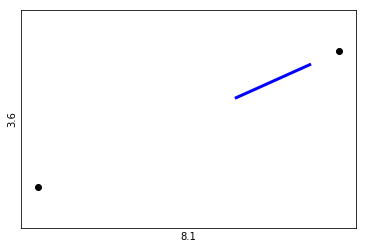

[1.35 2.35 1.45 0.86 1.01 2.61 0.61 1.62 2.82 2.77]
[2.81 -3.24 3.01 0.2 1.08 1.55]


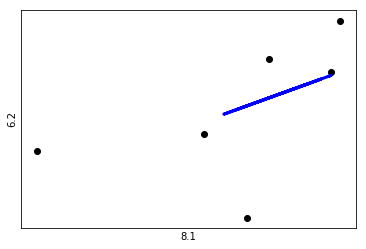

[1.55 1.35 2.35 0.86 1.01 2.61 0.61 1.62 2.82 2.77]
[2.81 -3.24 3.01 0.2 1.08]


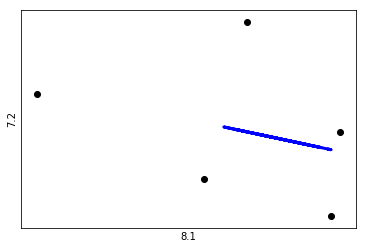

[1.45 1.01 1.62]
[1.08 1.35]


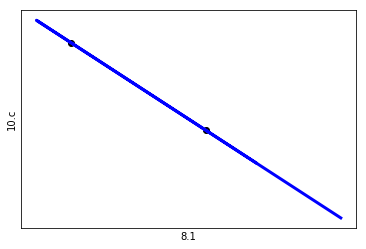

[1.45 2.82]
[3.01 2.35]


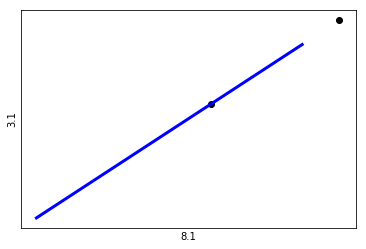

[1.35 2.35 1.45 0.86 1.01 2.61 0.61 1.62 2.82 2.77]
[2.81 -3.24 3.01 0.2 1.08 1.55]


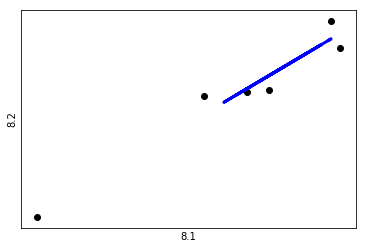

[1.35 2.35 1.45 0.86 1.01 2.61 0.61 1.62 2.82 2.77]
[2.81 -3.24 3.01 0.2 1.08 1.55]


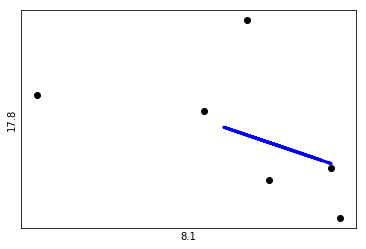

[1.35 2.35 1.45 0.86 1.01 2.61 0.61 1.62 2.82 2.77]
[2.81 -3.24 3.01 0.2 1.08 1.55]


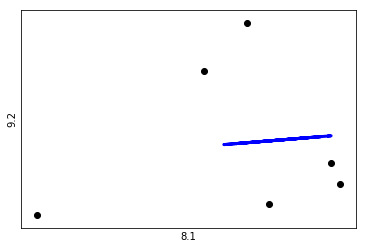

[1.35 2.35 1.45 0.86 1.01 2.61 0.61 1.62 2.82 2.77]
[2.81 -3.24 3.01 0.2 1.08 1.55]


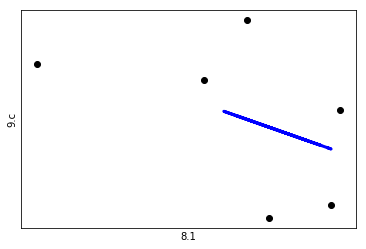

[1.35 2.35 1.45 0.86 1.01 2.61 0.61 1.62 2.82 2.77]
[2.81 -3.24 3.01 0.2 1.08 1.55]


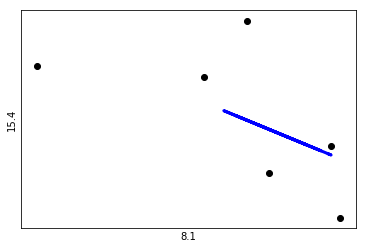

[1.45 2.82]
[3.01 2.35]


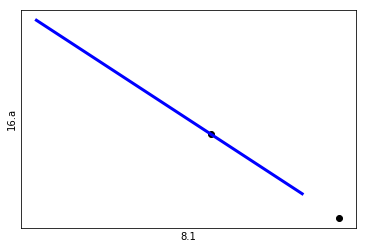

[0.2 1.08 1.62 2.77]
[2.81 -3.24 3.01]


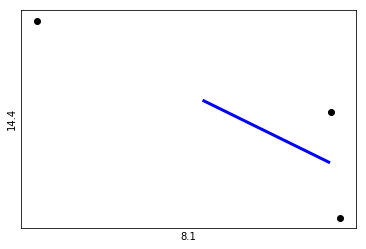

[2.35 2.82]
[3.01 1.35]


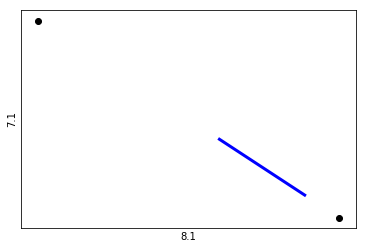

[1.35 2.35 1.45 0.86 1.01 2.61 0.61 1.62 2.82 2.77]
[2.81 -3.24 3.01 0.2 1.08 1.55]


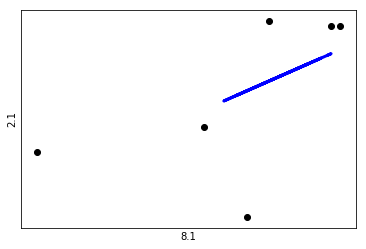

[1.35 2.35 1.45 0.86 1.01 2.61 0.61 1.62 2.82 2.77]
[2.81 -3.24 3.01 0.2 1.08 1.55]


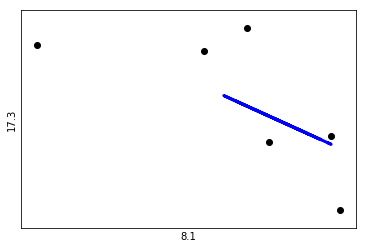

[2.82]
[1.35]
[1.45 2.82]
[3.01 2.35]


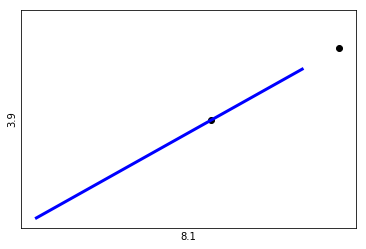

[1.35 2.35 1.45 0.86 1.01 2.61 0.61 1.62 2.82 2.77]
[2.81 -3.24 3.01 0.2 1.08 1.55]


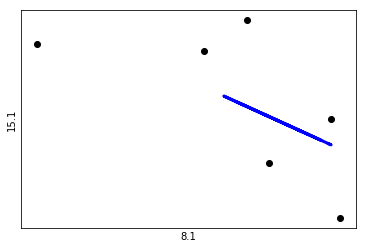

[1.45 2.82]
[3.01 2.35]


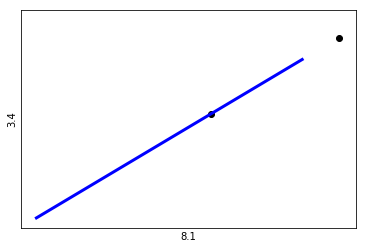

[1.35 1.01 2.61 1.62 2.82 2.77]
[-3.24 0.2 1.08]


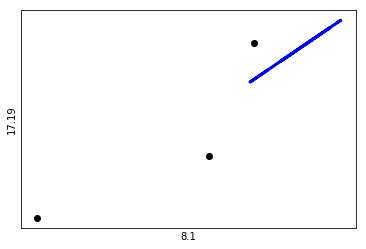

[1.55 1.35 2.35 1.01 2.61 1.62 2.82 2.77]
[2.81 -3.24 0.2 1.08]


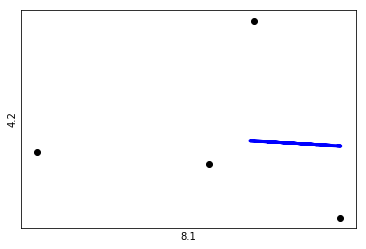

[1.35 2.35 1.45 0.86 1.01 2.61 0.61 1.62 2.82 2.77]
[2.81 -3.24 3.01 0.2 1.08 1.55]


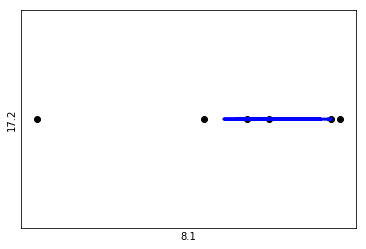

[1.35 2.35 1.45 0.86 1.01 2.61 0.61 1.62 2.82 2.77]
[2.81 -3.24 3.01 0.2 1.08 1.55]


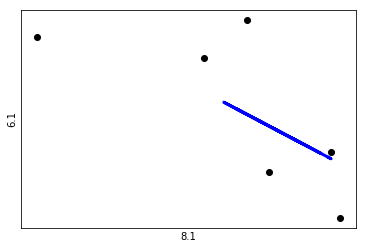

[1.45 2.82]
[3.01 2.35]


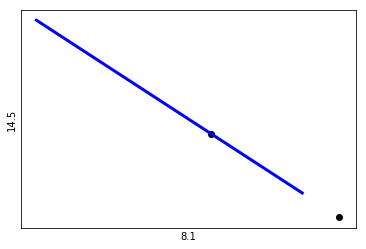

[1.35 2.35 1.45 0.86 1.01 2.61 0.61 1.62 2.82 2.77]
[2.81 -3.24 3.01 0.2 1.08 1.55]


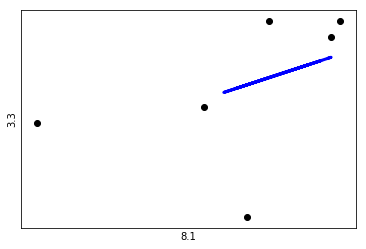

In [60]:
keep =[]
processedPairs = list()
tonsTargets = ['12.2', '9.4', '8.4']

for targetx in targets:     #loop over all rows
        
        for targety in targets:    #loop over all rows except the one we're in now
            # avoid double processing of reverse pairs
            if not set([targetx, targety]) in processedPairs:
                processedPairs.extend([set([targetx, targety])])
                
                if not targety==targetx:
                    
                    
                    # TODO: modify, account for both tonnes, USD etc, find a different solution maybe considering percent
                    if ((targety in tonsTargets and not targetx in tonsTargets) or targety=='9.4'):
                        y = targetx
                        x = targety
                        targetx = x
                        targety = y


                    X = final_t_shuffled[targetx].reshape(-1,1)
                    Y = final_t_shuffled[targety].reshape(-1,1)

                    # apply mask to lists to filter out pairs containing any NaNs
                    mask = ~pd.isnull(X) & ~pd.isnull(Y)

                    X = X[mask]
                    Y = Y[mask]


                    # Split the data into training/testing sets
                    split = math.floor(2/3 * len(X))
                    X_train = X[:-split]
                    Y_train = Y[:-split]

                    X_valid = X[-split:]
                    Y_valid = Y[-split:]

                    print(X_valid)
                    print(X_train)

                    if (len(X_train) > 1):

                        X_train = X_train.reshape(-1, 1)
                        Y_train = Y_train.reshape(-1, 1)
                        
                        X_valid = X_valid.reshape(-1, 1)
                        Y_valid = Y_valid.reshape(-1, 1)

                        linreg = linear_model.LinearRegression()
                        linreg.fit(X_train, Y_train)
                        
                        # Make predictions using the testing set
                        y_pred = linreg.predict(X_valid)

                        plt.scatter(X_train, Y_train,  color='black')
                        plt.plot(X_valid, y_pred, color='blue', linewidth=3)

                        plt.xticks(())
                        plt.yticks(())
                        plt.xlabel(targetx)
                        plt.ylabel(targety)
                        plt.show()

    #print(keep)

In [32]:
np.isnan(float(X[0]))

True

In [46]:
pd.isnull(X)

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True]], dtype=bool)

In [ ]:
# @Galina: look what I found
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [ ]:
corr, mae, rae, rmse, r2 = compute_error(y_mis1, y_hat)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

what needs to be done before

In [ ]:
# convert data to a matrix
y = df.as_matrix()
y = y[:(6*24*1)]
N, D = y.shape
print("N=%d, D=%d" % (N,D))

In [ ]:
missing_perc = 0.8 # missing percentage

perm1 = np.random.permutation(N)
ix_mis1 = perm1[:int(missing_perc * N)] # missing indexes
ix_obs1 = perm1[int(missing_perc * N):] # observed indexes
y_mis1 = y[ix_mis1,7]
y_obs1 = y[ix_obs1,7]

perm2 = np.random.permutation(N)
ix_mis2 = perm2[:int(missing_perc * N)] # missing indexes
ix_obs2 = perm2[int(missing_perc * N):] # observed indexes
y_mis2 = y[ix_mis2,8]
y_obs2 = y[ix_obs2,8]

N_obs = len(ix_obs1)
N_mis = len(ix_mis1)
print("N_obs:", N_obs)
print("N_mis:", N_mis)

## Define STAN model

In [ ]:
SDG_STAN="""
data {
    int<lower = 0> N_obs;    // we might need such a variable for each observed variable because they could be different
    int<lower = 0> N_mis;    // how many do we want to infer
    int<lower = 1, upper = N_obs + N_mis> ix_obs1[N_obs];    // index for observed variable 1
    int<lower = 1, upper = N_obs + N_mis> ix_mis1[N_mis];
    int<lower = 1, upper = N_obs + N_mis> ix_obs2[N_obs];    // index for observed variable 2 -> more?
    int<lower = 1, upper = N_obs + N_mis> ix_mis2[N_mis];
    real y_obs1[N_obs];         // observed time-series data for variable 1
    real y_obs2[N_obs];         // observed time-series data for variable 2
}
parameters {
    vector[1] beta[2];            // state transition coefficients
    corr_matrix[2] Omega;    // 2 because of two observed variables -> in our case 
    vector<lower=0>[2] tau;
    real<lower=0> sigma;       // observation noise
    matrix[T,2] z;             // vector of latent states
    real y_mis1[N_mis];        // missing time-series data (to infer)
    real y_mis2[N_mis];        // missing time-series data (to infer)
}
model {
    for(i in 1:2)                   // 2 again because of two observed variables
        beta[i] ~ normal(0,1);            // prior on the auto-regressive coefficients
    tau ~ cauchy(0,1);
    Omega ~ lkj_corr(10.0);         // STAN manual Section 63.1  
    sigma ~ cauchy(0,1);            // prior on the variance
    
    z[1,:] ~ normal(0,1);           // prior on first state
    for(t in 2:T) {
        vector[2] mu;
        mu[1] = beta[1]' * z[(t-1):(t-1),1];
        mu[2] = beta[2]' * z[(t-1):(t-1),2];
        z[t,:] ~ multi_normal(mu, quad_form_diag(Omega, tau)); // latent dynamics
    }
    
    y1 ~ normal(z[:,1], sigma);    // likelihood
    y2 ~ normal(z[:,2], sigma);    // likelihood
}
"""

In [ ]:
# prepare data for STAN model
data = {'N_obs': N_obs, 'N_mis': N_mis, 
        'ix_obs1': ix_obs1+1, 'ix_mis1': ix_mis1+1, 'y_obs1': y_obs1, 
        'ix_obs2': ix_obs2+1, 'ix_mis2': ix_mis2+1, 'y_obs2': y_obs2}

In [ ]:
%%time
# create STAN model object (compile STAN model)
sm = pystan.StanModel(model_code=SDG_STAN)

In [ ]:
# run inference using MCMC sampling
fit = sm.sampling(data=data, iter=500, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit)

In [ ]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays

In [ ]:
fit.plot(["tau","sigma","lp__"])
plt.show()

#### Compute mean and standard devitions for the imputed values of the time-series and visualize them (in comparison with the corresponding true values):

In [ ]:
# get mean and standard devitions for predictions
y_hat = samples["y_mis1"].mean(axis=0)
y_std = samples["y_mis1"].std(axis=0)

In [ ]:
plt.plot(ix_obs1, y_obs1, "bo")
plt.plot(ix_mis1, y_mis1, "bx")
plt.plot(ix_mis1, y_hat, "rx")
#plt.plot(ix_mis, y_hat + y_std, "r--")
#plt.plot(ix_mis, y_hat - y_std, "r--")
plt.legend(["true","forecast","forecast + stddev","forecast - stddev"])

Compute error statistics of the model's imputations:

In [ ]:
# insert def compute_error if deleted above
corr, mae, rae, rmse, r2 = compute_error(y_mis1, y_hat)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))